<a href="https://colab.research.google.com/github/deeeepak7/study_of_models_on_chestXray/blob/main/5fold_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **cnn **

Training images: 400
Test images: 100

========== FOLD 1 ==========
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 334ms/step - accuracy: 0.5319 - auc: 0.5920 - loss: 0.6912 - val_accuracy: 0.5125 - val_auc: 0.7234 - val_loss: 0.6891
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.5611 - auc: 0.6933 - loss: 0.6848 - val_accuracy: 0.5875 - val_auc: 0.7606 - val_loss: 0.6851
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.6427 - auc: 0.7022 - loss: 0.6818 - val_accuracy: 0.6000 - val_auc: 0.7719 - val_loss: 0.6783
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.6773 - auc: 0.8040 - loss: 0.6668 - val_accuracy: 0.6125 - val_auc: 0.7706 - val_loss: 0.6680
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.7092 - auc: 0.7752 - loss: 0.6430 - val_accuracy: 0.5875 - val_auc: 0.7434 - val_loss: 0.6572
Fold 1 time: 0.61 minutes

Fold 1 Confusion Matrix:
[[17 23]
 [10 30]]

========== FOLD 2 ==========
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━

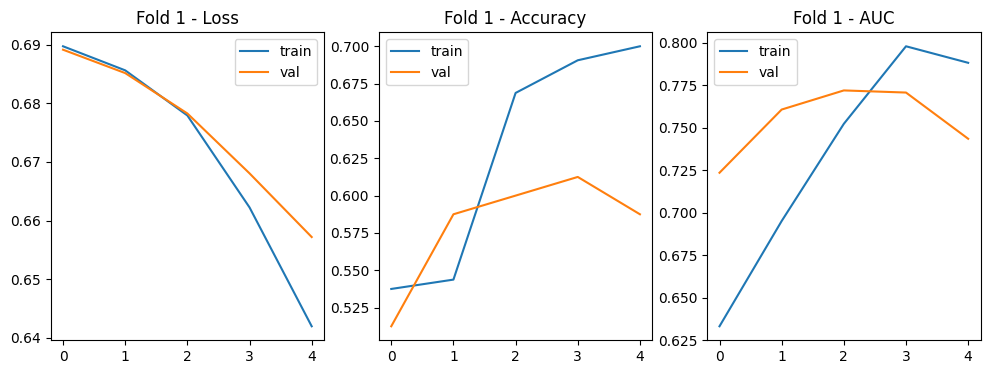

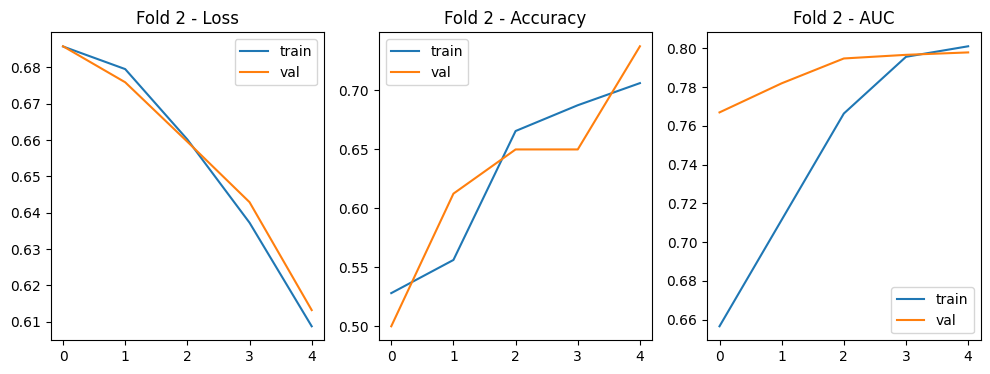

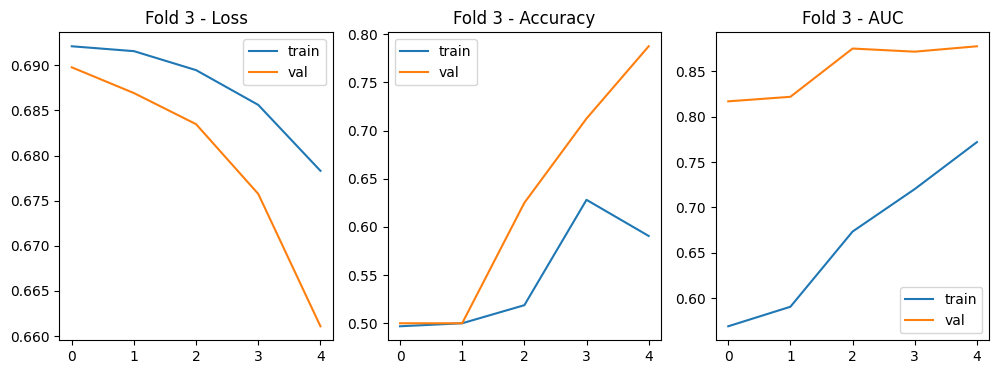

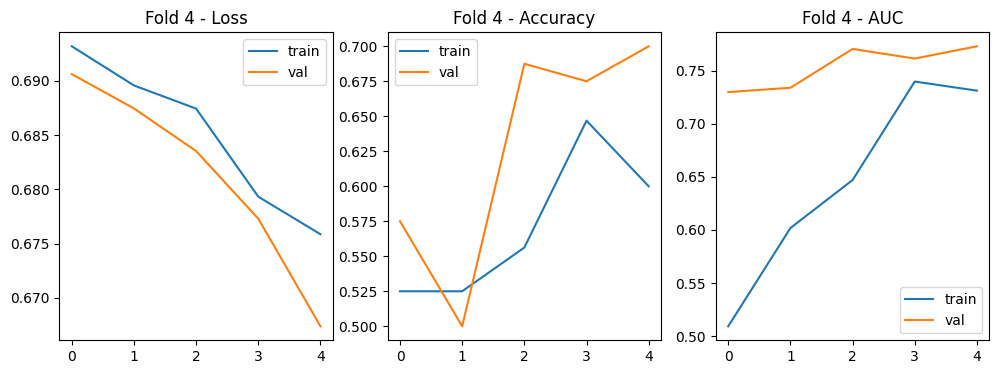

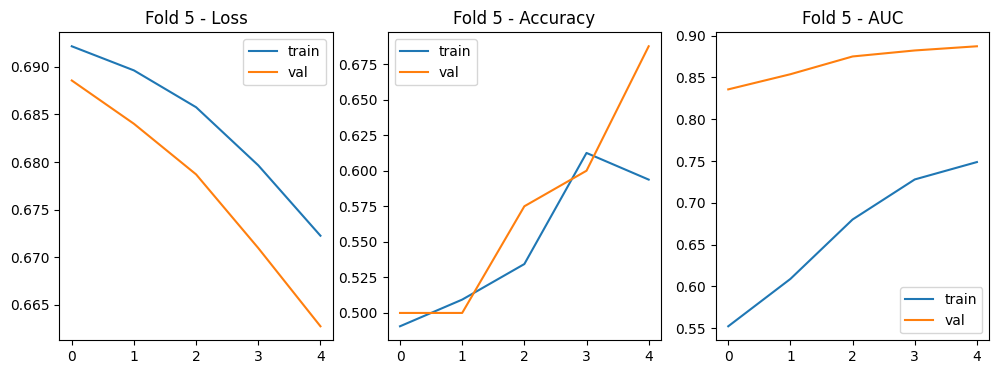

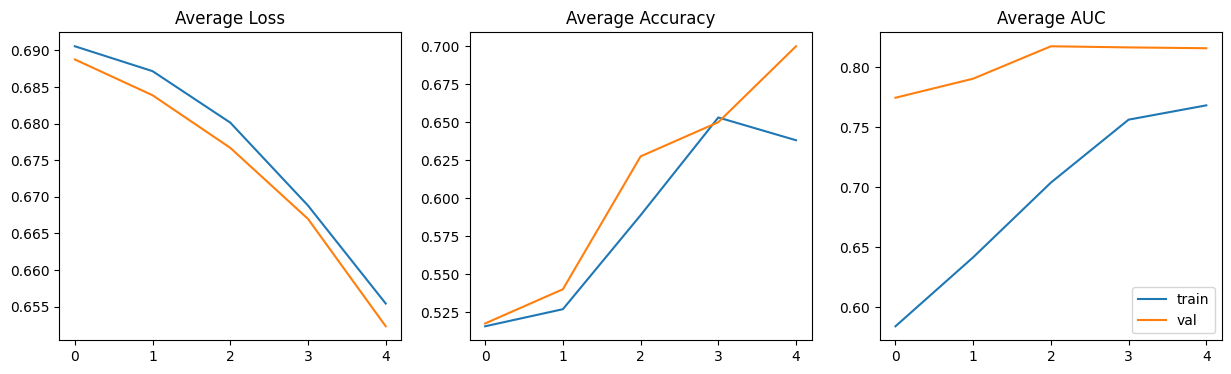

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.5116 - auc: 0.5190 - loss: 0.6922
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.5241 - auc: 0.5565 - loss: 0.6914
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.5562 - auc: 0.6931 - loss: 0.6801
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5981 - auc: 0.6478 - loss: 0.6798
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5834 - auc: 0.7077 - loss: 0.6742

===== FINAL TEST CONFUSION MATRIX =====
[[48  2]
 [49  1]]

===== FINAL TEST CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

      normal       0.49      0.96      0.65        50
          tb       0.33      0.02      0.04        50

    accuracy                           0.49       100
   macro avg       0.41      0.49      0.35       100
weighted avg       0.41      0.49      0.35       100



In [4]:
# ============================================================
# CNN + 5-FOLD STRATIFIED CV
# WITH TIME, PLOTS, CONFUSION MATRICES, FINAL TEST EVALUATION
# ============================================================

!pip -q install tensorflow matplotlib scikit-learn

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 1) CONSTANTS & PATHS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
SEED = 42

CLASS_NAMES = ["normal", "tb"]

tf.random.set_seed(SEED)
np.random.seed(SEED)

# =========================
# 2) COLLECT TRAIN IMAGES
# =========================
train_paths, train_labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "train")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            train_paths.append(os.path.join(folder, f))
            train_labels.append(label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

print("Training images:", len(train_paths))

# =========================
# 3) COLLECT TEST IMAGES
# =========================
test_paths, test_labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "test")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            test_paths.append(os.path.join(folder, f))
            test_labels.append(label)

test_paths = np.array(test_paths)
test_labels = np.array(test_labels)

print("Test images:", len(test_paths))

# =========================
# 4) DATASET BUILDER
# =========================
def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def parse(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        return img, tf.cast(label, tf.float32)

    ds = ds.map(parse, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000, seed=SEED)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 5) CNN MODEL
# =========================
def build_model():
    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))

    x = tf.keras.layers.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.RandomRotation(0.05)(x)
    x = tf.keras.layers.RandomZoom(0.1)(x)

    x = tf.keras.layers.Rescaling(1./255)(x)

    for filters in [32, 64, 128, 256]:
        x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

# =========================
# 6) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

histories = []
fold_times = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(train_paths, train_labels), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_dataset(train_paths[tr], train_labels[tr], True)
    val_ds   = make_dataset(train_paths[va], train_labels[va], False)

    model = build_model()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )

    fold_time = time.time() - fold_start
    fold_times.append(fold_time)

    print(f"Fold {fold} time: {fold_time/60:.2f} minutes")

    histories.append(history.history)

    # Fold confusion matrix
    y_true, y_pred = [], []
    for imgs, labs in val_ds:
        probs = model.predict(imgs, verbose=0).ravel()
        y_pred.extend((probs >= 0.5).astype(int))
        y_true.extend(labs.numpy().astype(int))

    print(f"\nFold {fold} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

cv_total_time = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total_time/60:.2f} minutes")

# =========================
# 7) FOLD-WISE TRAINING CURVES
# =========================
for i, h in enumerate(histories, 1):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.plot(h["loss"], label="train")
    plt.plot(h["val_loss"], label="val")
    plt.title(f"Fold {i} - Loss")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(h["accuracy"], label="train")
    plt.plot(h["val_accuracy"], label="val")
    plt.title(f"Fold {i} - Accuracy")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(h["auc"], label="train")
    plt.plot(h["val_auc"], label="val")
    plt.title(f"Fold {i} - AUC")
    plt.legend()

    plt.show()

# =========================
# 8) AVERAGE CV CURVES
# =========================
def avg_curve(key):
    return np.mean([h[key] for h in histories], axis=0)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(avg_curve("loss"), label="train")
plt.plot(avg_curve("val_loss"), label="val")
plt.title("Average Loss")

plt.subplot(1,3,2)
plt.plot(avg_curve("accuracy"), label="train")
plt.plot(avg_curve("val_accuracy"), label="val")
plt.title("Average Accuracy")

plt.subplot(1,3,3)
plt.plot(avg_curve("auc"), label="train")
plt.plot(avg_curve("val_auc"), label="val")
plt.title("Average AUC")

plt.legend()
plt.show()

# =========================
# 9) FINAL TRAIN ON FULL TRAIN SET
# =========================
final_model = build_model()
final_model.fit(
    make_dataset(train_paths, train_labels, True),
    epochs=EPOCHS,
    verbose=1
)

# =========================
# 10) FINAL TEST EVALUATION
# =========================
test_ds = make_dataset(test_paths, test_labels, False)

y_true, y_pred = [], []
for imgs, labs in test_ds:
    probs = final_model.predict(imgs, verbose=0).ravel()
    y_pred.extend((probs >= 0.5).astype(int))
    y_true.extend(labs.numpy().astype(int))

print("\n===== FINAL TEST CONFUSION MATRIX =====")
print(confusion_matrix(y_true, y_pred))

print("\n===== FINAL TEST CLASSIFICATION REPORT =====")
print(classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES
))


# **resnet50**

Training images: 400
Normal: 200 TB: 200

========== FOLD 1 ==========
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5185 - auc: 0.5254 - loss: 0.9550 - val_accuracy: 0.6000 - val_auc: 0.8450 - val_loss: 0.6409
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.7770 - auc: 0.8449 - loss: 0.5034 - val_accuracy: 0.6500 - val_auc: 0.9175 - val_loss: 0.5922
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.8102 - auc: 0.8746 - loss: 0.4374 - val_accuracy: 0.6750 - val_auc: 0.9512 - val_loss: 0.5477
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.8256 - auc: 0.9064 - loss: 0.3995 - val_accuracy: 0.7125 - val_auc: 0.9638 - val_loss: 0.4951
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.8830 - auc: 0.9626 - loss: 0.2515 - val_accuracy: 0.7375 - val_auc: 0.9697 - val_loss: 0.4492
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.8778 - auc: 0.


Fold 3 Confusion Matrix:
[[40  0]
 [ 5 35]]

========== FOLD 4 ==========
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 480ms/step - accuracy: 0.5525 - auc: 0.6071 - loss: 0.8270 - val_accuracy: 0.7875 - val_auc: 0.9178 - val_loss: 0.5389
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.6611 - auc: 0.8016 - loss: 0.5817 - val_accuracy: 0.9500 - val_auc: 0.9688 - val_loss: 0.4015
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.8436 - auc: 0.9016 - loss: 0.4009 - val_accuracy: 0.9125 - val_auc: 0.9772 - val_loss: 0.3485
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.8338 - auc: 0.9170 - loss: 0.3717 - val_accuracy: 0.9125 - val_auc: 0.9800 - val_loss: 0.3131
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.8671 - auc: 0.9406 - loss: 0.3125 - val_accuracy: 0.9125 - val_auc: 0.9800 - val_loss: 0.2894
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.8719 - auc: 0.9403 - loss: 0.3128 - val_accuracy: 0.9250 -

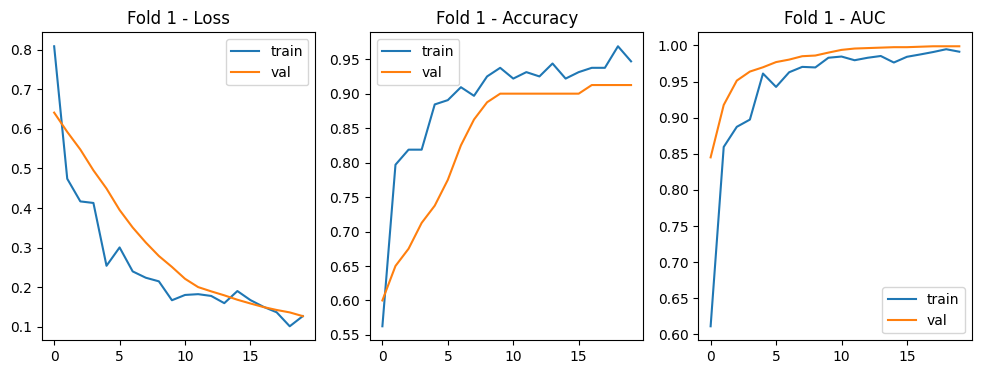

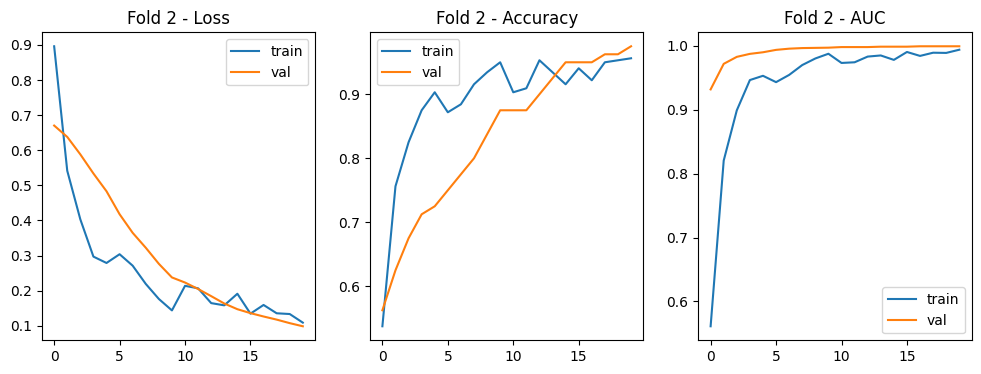

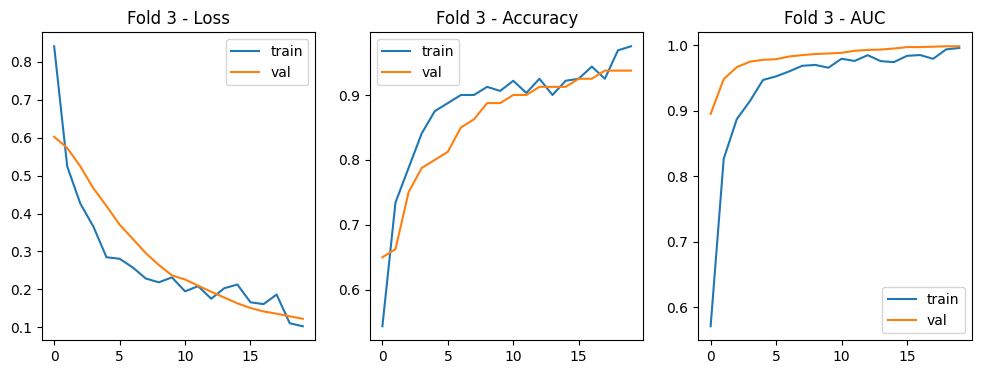

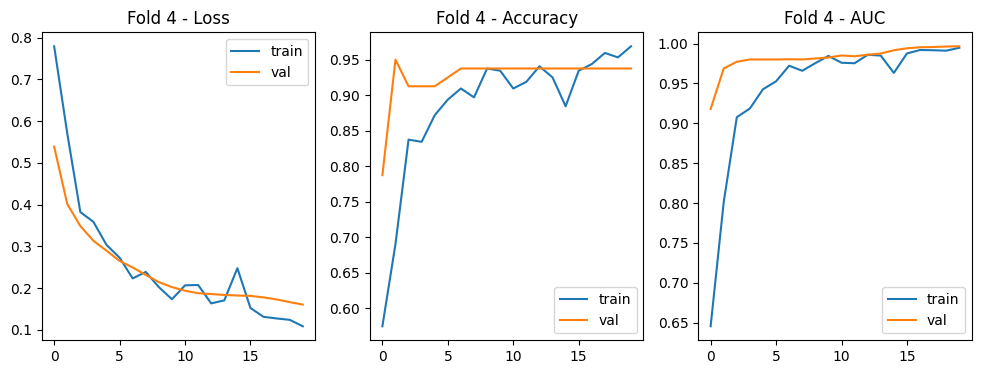

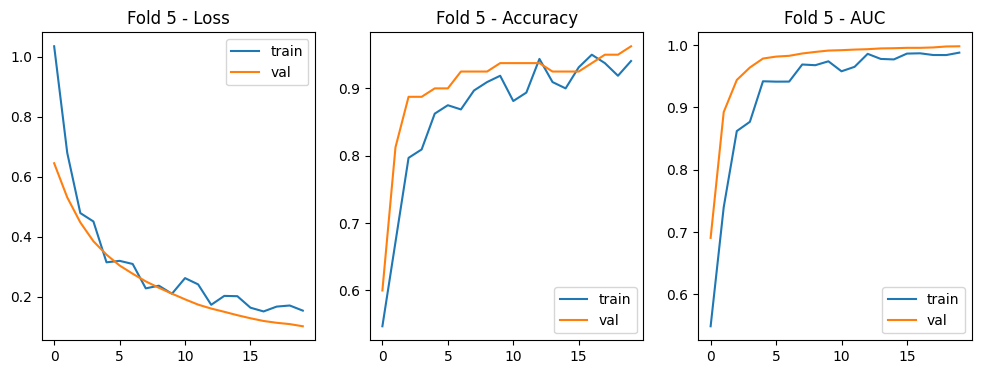

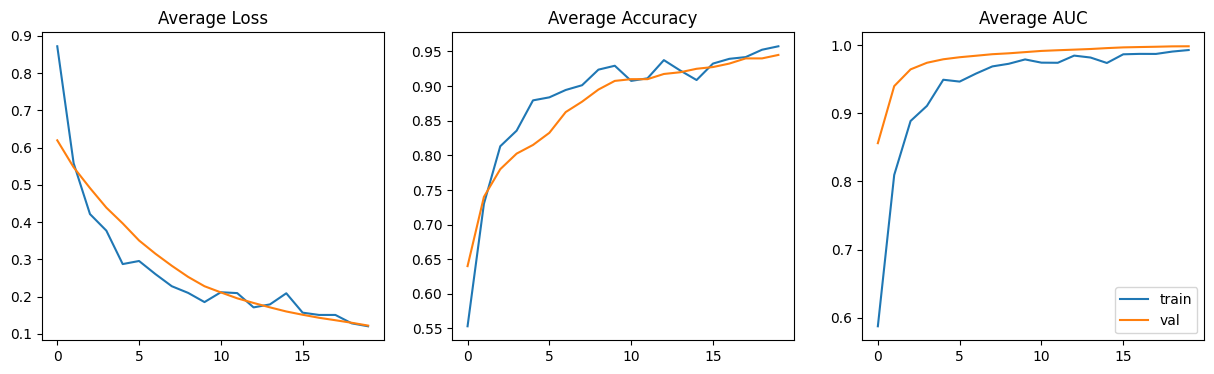

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.4922 - auc: 0.4830 - loss: 0.9815
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.6961 - auc: 0.7880 - loss: 0.5938
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.8054 - auc: 0.8783 - loss: 0.4392
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.8618 - auc: 0.9388 - loss: 0.3305
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.8875 - auc: 0.9540 - loss: 0.2763
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.8748 - auc: 0.9514 - loss: 0.2829
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.8994 - auc: 0.9554 - loss: 0.2775
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9422 - auc: 0.9853 - loss: 0.1680
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9221 - auc: 0.9801 - loss: 0.1867
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9286 - auc: 0.9715 - loss: 0.216

In [3]:
# ============================================================
# RESNET50 + 5-FOLD STRATIFIED CV + FINE-TUNING
# WITH TIME, PLOTS, CONFUSION MATRICES, FINAL TEST EVALUATION
# ============================================================

!pip -q install tensorflow matplotlib scikit-learn

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 1) PATHS & PARAMETERS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 10
SEED = 42

CLASS_NAMES = ["normal", "tb"]

tf.random.set_seed(SEED)
np.random.seed(SEED)

# =========================
# 2) COLLECT TRAIN IMAGES
# =========================
image_paths, labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "train")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(folder, f))
            labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Training images:", len(image_paths))
print("Normal:", np.sum(labels == 0), "TB:", np.sum(labels == 1))

# =========================
# 3) DATASET BUILDER
# =========================
def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def parse(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        return img, tf.cast(label, tf.float32)

    ds = ds.map(parse, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000, seed=SEED)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 4) MODEL BUILDER
# =========================
def build_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = tf.keras.layers.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.RandomRotation(0.05)(x)
    x = tf.keras.layers.RandomZoom(0.1)(x)

    x = tf.keras.applications.resnet50.preprocess_input(x)

    base_model = tf.keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        input_tensor=x
    )
    base_model.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# =========================
# 5) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

histories = []
fold_times = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(image_paths, labels), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_dataset(image_paths[tr], labels[tr], True)
    val_ds   = make_dataset(image_paths[va], labels[va], False)

    model, base_model = build_model()

    # ----- STAGE 1: FROZEN -----
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    t1 = time.time()
    hist1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE1,
        verbose=1
    )
    t1 = time.time() - t1

    # ----- STAGE 2: FINE-TUNING -----
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    t2 = time.time()
    hist2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE2,
        verbose=1
    )
    t2 = time.time() - t2

    fold_time = time.time() - fold_start
    fold_times.append((t1, t2, fold_time))

    print(f"Stage-1 time: {t1/60:.2f} min")
    print(f"Stage-2 time: {t2/60:.2f} min")
    print(f"Total fold time: {fold_time/60:.2f} min")

    # Merge histories
    history = {}
    for k in hist1.history:
        history[k] = hist1.history[k] + hist2.history[k]
    histories.append(history)

    # Fold confusion matrix
    y_true, y_pred = [], []
    for imgs, labs in val_ds:
        probs = model.predict(imgs, verbose=0).ravel()
        y_pred.extend((probs >= 0.5).astype(int))
        y_true.extend(labs.numpy().astype(int))

    print(f"\nFold {fold} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

cv_total_time = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total_time/60:.2f} minutes")

# =========================
# 6) FOLD-WISE TRAINING CURVES
# =========================
for i, h in enumerate(histories, 1):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.plot(h["loss"], label="train")
    plt.plot(h["val_loss"], label="val")
    plt.title(f"Fold {i} - Loss")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(h["accuracy"], label="train")
    plt.plot(h["val_accuracy"], label="val")
    plt.title(f"Fold {i} - Accuracy")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(h["auc"], label="train")
    plt.plot(h["val_auc"], label="val")
    plt.title(f"Fold {i} - AUC")
    plt.legend()

    plt.show()

# =========================
# 7) AVERAGE CV CURVES
# =========================
def avg_curve(key):
    return np.mean([h[key] for h in histories], axis=0)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(avg_curve("loss"), label="train")
plt.plot(avg_curve("val_loss"), label="val")
plt.title("Average Loss")

plt.subplot(1,3,2)
plt.plot(avg_curve("accuracy"), label="train")
plt.plot(avg_curve("val_accuracy"), label="val")
plt.title("Average Accuracy")

plt.subplot(1,3,3)
plt.plot(avg_curve("auc"), label="train")
plt.plot(avg_curve("val_auc"), label="val")
plt.title("Average AUC")

plt.legend()
plt.show()

# =========================
# 8) FINAL TRAIN ON FULL TRAIN SET
# =========================
final_model, final_base = build_model()

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

final_model.fit(
    make_dataset(image_paths, labels, True),
    epochs=EPOCHS_STAGE1,
    verbose=1
)

for layer in final_base.layers[-30:]:
    layer.trainable = True

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

final_model.fit(
    make_dataset(image_paths, labels, True),
    epochs=EPOCHS_STAGE2,
    verbose=1
)

# =========================
# 9) FINAL TEST EVALUATION
# =========================
test_paths, test_labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "test")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            test_paths.append(os.path.join(folder, f))
            test_labels.append(label)

test_ds = make_dataset(np.array(test_paths), np.array(test_labels), False)

y_true, y_pred = [], []
for imgs, labs in test_ds:
    probs = final_model.predict(imgs, verbose=0).ravel()
    y_pred.extend((probs >= 0.5).astype(int))
    y_true.extend(labs.numpy().astype(int))

print("\n===== FINAL TEST CONFUSION MATRIX =====")
print(confusion_matrix(y_true, y_pred))

print("\n===== FINAL TEST CLASSIFICATION REPORT =====")
print(classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES
))


# **efficientnet**

Training images: 400
Normal: 200 TB: 200

========== FOLD 1 ==========
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 568ms/step - accuracy: 0.5914 - auc: 0.6674 - loss: 0.7757 - val_accuracy: 0.6125 - val_auc: 0.7691 - val_loss: 0.6382
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.7172 - auc: 0.7867 - loss: 0.6085 - val_accuracy: 0.7000 - val_auc: 0.8681 - val_loss: 0.5954
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.7522 - auc: 0.8411 - loss: 0.4936 - val_accuracy: 0.7125 - val_auc: 0.9019 - val_loss: 0.5580
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.7739 - auc: 0.8625 - loss: 0.4703 - val_accuracy: 0.7375 - val_auc: 0.9216 - val_loss: 0.5288
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.7935 - auc: 0.8752 - loss: 0.4424 - val_accuracy: 0.7500 - val_auc: 0.9341 - val_loss: 0.5075
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.8203 - auc:

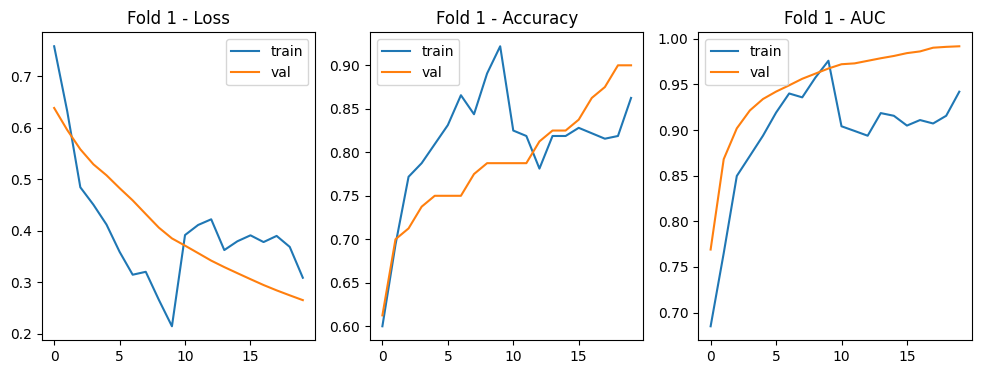

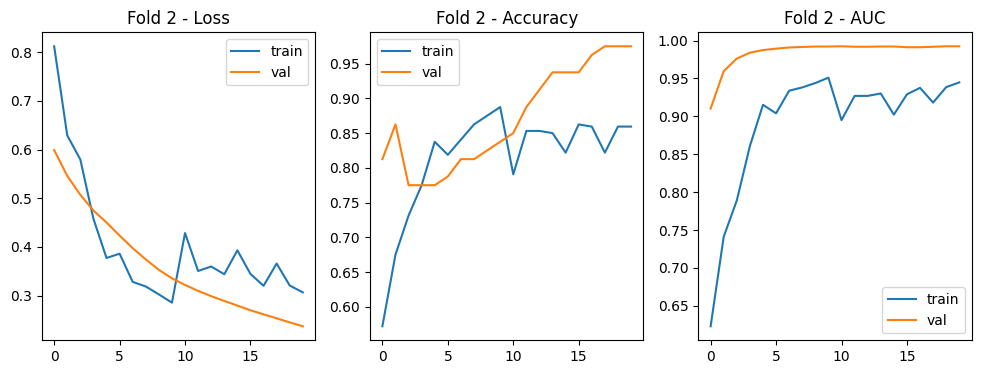

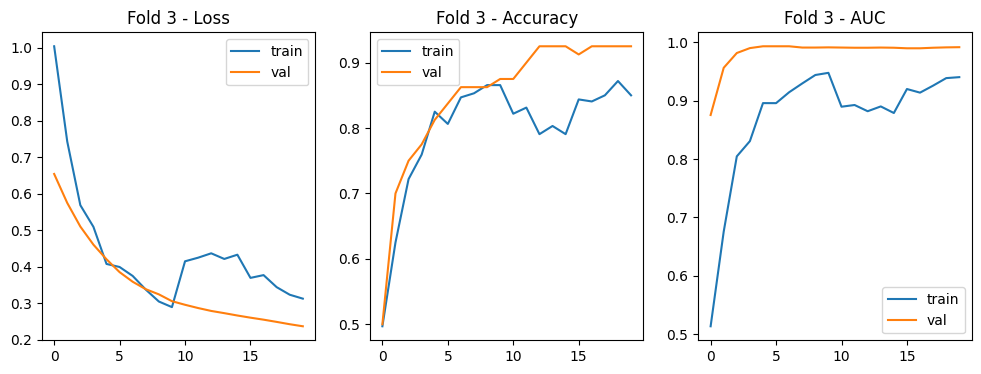

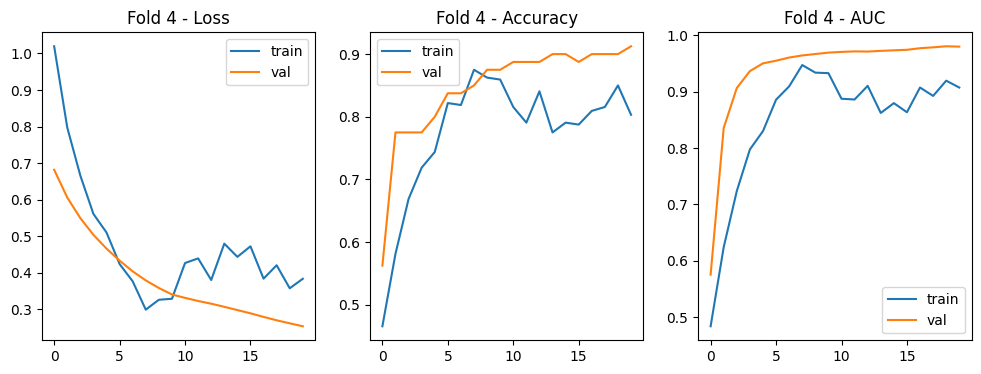

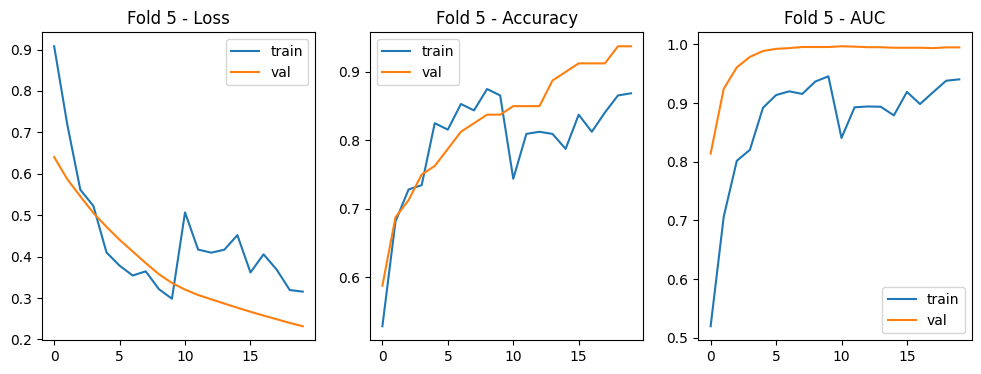

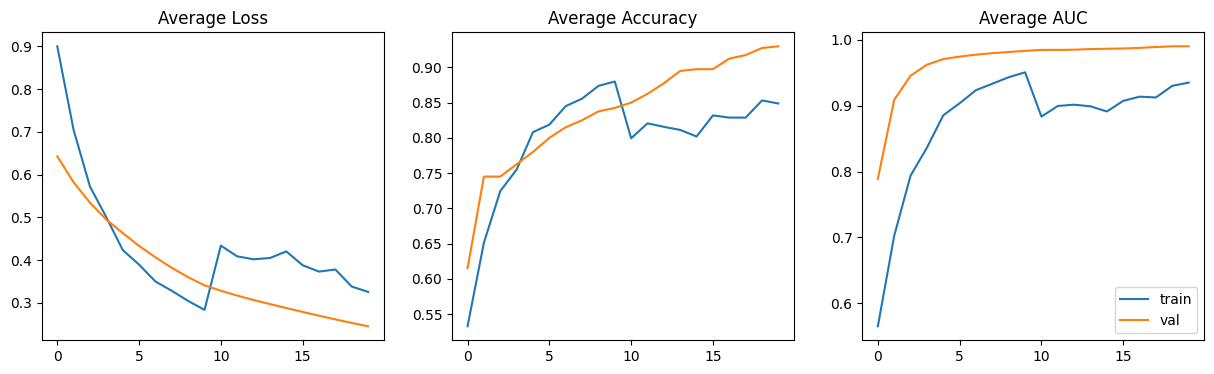

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.4243 - auc: 0.3943 - loss: 1.2461
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.6016 - auc: 0.6465 - loss: 0.8154
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6764 - auc: 0.7675 - loss: 0.6158
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.7438 - auc: 0.8185 - loss: 0.5097
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.7546 - auc: 0.8554 - loss: 0.4722
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8332 - auc: 0.9165 - loss: 0.3676
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.8670 - auc: 0.9393 - loss: 0.3134
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8374 - auc: 0.9202 - loss: 0.3467
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8464 - auc: 0.9331 - loss: 0.3377
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8358 - auc: 0.9515 - loss: 0.2770
Epoch 1/

In [5]:
# ============================================================
# EFFICIENTNET + 5-FOLD STRATIFIED CV + FINE-TUNING
# WITH TIME, PLOTS, CONFUSION MATRICES, FINAL TEST EVALUATION
# ============================================================

!pip -q install tensorflow matplotlib scikit-learn

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 1) PATHS & PARAMETERS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 10
SEED = 42

CLASS_NAMES = ["normal", "tb"]

tf.random.set_seed(SEED)
np.random.seed(SEED)

# =========================
# 2) COLLECT TRAIN IMAGES
# =========================
image_paths, labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "train")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(folder, f))
            labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Training images:", len(image_paths))
print("Normal:", np.sum(labels == 0), "TB:", np.sum(labels == 1))

# =========================
# 3) DATASET BUILDER
# =========================
def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def parse(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        return img, tf.cast(label, tf.float32)

    ds = ds.map(parse, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000, seed=SEED)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 4) MODEL BUILDER (EFFICIENTNET)
# =========================
def build_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = tf.keras.layers.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.RandomRotation(0.05)(x)
    x = tf.keras.layers.RandomZoom(0.1)(x)

    x = tf.keras.applications.efficientnet.preprocess_input(x)

    base_model = tf.keras.applications.EfficientNetB0(
        weights="imagenet",
        include_top=False,
        input_tensor=x
    )
    base_model.trainable = False  # Stage-1 frozen

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# =========================
# 5) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

histories = []
fold_times = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(image_paths, labels), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_dataset(image_paths[tr], labels[tr], True)
    val_ds   = make_dataset(image_paths[va], labels[va], False)

    model, base_model = build_model()

    # ---------- STAGE 1: FROZEN ----------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    t1 = time.time()
    hist1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE1,
        verbose=1
    )
    t1 = time.time() - t1

    # ---------- STAGE 2: FINE-TUNING ----------
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    t2 = time.time()
    hist2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE2,
        verbose=1
    )
    t2 = time.time() - t2

    fold_time = time.time() - fold_start
    fold_times.append((t1, t2, fold_time))

    print(f"Stage-1 time: {t1/60:.2f} min")
    print(f"Stage-2 time: {t2/60:.2f} min")
    print(f"Total fold time: {fold_time/60:.2f} min")

    # Merge histories
    history = {}
    for k in hist1.history:
        history[k] = hist1.history[k] + hist2.history[k]
    histories.append(history)

    # Fold confusion matrix
    y_true, y_pred = [], []
    for imgs, labs in val_ds:
        probs = model.predict(imgs, verbose=0).ravel()
        y_pred.extend((probs >= 0.5).astype(int))
        y_true.extend(labs.numpy().astype(int))

    print(f"\nFold {fold} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

cv_total_time = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total_time/60:.2f} minutes")

# =========================
# 6) FOLD-WISE TRAINING CURVES
# =========================
for i, h in enumerate(histories, 1):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.plot(h["loss"], label="train")
    plt.plot(h["val_loss"], label="val")
    plt.title(f"Fold {i} - Loss")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(h["accuracy"], label="train")
    plt.plot(h["val_accuracy"], label="val")
    plt.title(f"Fold {i} - Accuracy")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(h["auc"], label="train")
    plt.plot(h["val_auc"], label="val")
    plt.title(f"Fold {i} - AUC")
    plt.legend()

    plt.show()

# =========================
# 7) AVERAGE CV CURVES
# =========================
def avg_curve(key):
    return np.mean([h[key] for h in histories], axis=0)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(avg_curve("loss"), label="train")
plt.plot(avg_curve("val_loss"), label="val")
plt.title("Average Loss")

plt.subplot(1,3,2)
plt.plot(avg_curve("accuracy"), label="train")
plt.plot(avg_curve("val_accuracy"), label="val")
plt.title("Average Accuracy")

plt.subplot(1,3,3)
plt.plot(avg_curve("auc"), label="train")
plt.plot(avg_curve("val_auc"), label="val")
plt.title("Average AUC")

plt.legend()
plt.show()

# =========================
# 8) FINAL TRAIN ON FULL TRAIN SET
# =========================
final_model, final_base = build_model()

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

final_model.fit(
    make_dataset(image_paths, labels, True),
    epochs=EPOCHS_STAGE1,
    verbose=1
)

for layer in final_base.layers[-20:]:
    layer.trainable = True

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

final_model.fit(
    make_dataset(image_paths, labels, True),
    epochs=EPOCHS_STAGE2,
    verbose=1
)

# =========================
# 9) FINAL TEST EVALUATION
# =========================
test_paths, test_labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "test")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            test_paths.append(os.path.join(folder, f))
            test_labels.append(label)

test_ds = make_dataset(np.array(test_paths), np.array(test_labels), False)

y_true, y_pred = [], []
for imgs, labs in test_ds:
    probs = final_model.predict(imgs, verbose=0).ravel()
    y_pred.extend((probs >= 0.5).astype(int))
    y_true.extend(labs.numpy().astype(int))

print("\n===== FINAL TEST CONFUSION MATRIX =====")
print(confusion_matrix(y_true, y_pred))

print("\n===== FINAL TEST CLASSIFICATION REPORT =====")
print(classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES
))


# **mobilenet**

In [ ]:
# ============================================================
# MOBILENETV2 + 5-FOLD STRATIFIED CV + FINE-TUNING
# WITH TIME, PLOTS, CONFUSION MATRICES, FINAL TEST EVALUATION
# ============================================================

!pip -q install tensorflow matplotlib scikit-learn

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 1) PATHS & PARAMETERS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 10
SEED = 42

CLASS_NAMES = ["normal", "tb"]

tf.random.set_seed(SEED)
np.random.seed(SEED)

# =========================
# 2) COLLECT TRAIN IMAGES
# =========================
image_paths, labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "train")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(folder, f))
            labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Training images:", len(image_paths))
print("Normal:", np.sum(labels == 0), "TB:", np.sum(labels == 1))

# =========================
# 3) DATASET BUILDER
# =========================
def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def parse(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        return img, tf.cast(label, tf.float32)

    ds = ds.map(parse, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000, seed=SEED)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 4) MODEL BUILDER (MOBILENET)
# =========================
def build_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = tf.keras.layers.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.RandomRotation(0.05)(x)
    x = tf.keras.layers.RandomZoom(0.1)(x)

    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

    base_model = tf.keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_tensor=x
    )
    base_model.trainable = False  # Stage-1 frozen

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# =========================
# 5) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

histories = []
fold_times = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(image_paths, labels), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_dataset(image_paths[tr], labels[tr], True)
    val_ds   = make_dataset(image_paths[va], labels[va], False)

    model, base_model = build_model()

    # ---------- STAGE 1: FROZEN ----------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    t1 = time.time()
    hist1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE1,
        verbose=1
    )
    t1 = time.time() - t1

    # ---------- STAGE 2: FINE-TUNING ----------
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    t2 = time.time()
    hist2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE2,
        verbose=1
    )
    t2 = time.time() - t2

    fold_time = time.time() - fold_start
    fold_times.append((t1, t2, fold_time))

    print(f"Stage-1 time: {t1/60:.2f} min")
    print(f"Stage-2 time: {t2/60:.2f} min")
    print(f"Total fold time: {fold_time/60:.2f} min")

    # Merge histories
    history = {}
    for k in hist1.history:
        history[k] = hist1.history[k] + hist2.history[k]
    histories.append(history)

    # Fold confusion matrix
    y_true, y_pred = [], []
    for imgs, labs in val_ds:
        probs = model.predict(imgs, verbose=0).ravel()
        y_pred.extend((probs >= 0.5).astype(int))
        y_true.extend(labs.numpy().astype(int))

    print(f"\nFold {fold} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

cv_total_time = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total_time/60:.2f} minutes")

# =========================
# 6) FOLD-WISE TRAINING CURVES
# =========================
for i, h in enumerate(histories, 1):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.plot(h["loss"], label="train")
    plt.plot(h["val_loss"], label="val")
    plt.title(f"Fold {i} - Loss")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(h["accuracy"], label="train")
    plt.plot(h["val_accuracy"], label="val")
    plt.title(f"Fold {i} - Accuracy")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(h["auc"], label="train")
    plt.plot(h["val_auc"], label="val")
    plt.title(f"Fold {i} - AUC")
    plt.legend()

    plt.show()

# =========================
# 7) AVERAGE CV CURVES
# =========================
def avg_curve(key):
    return np.mean([h[key] for h in histories], axis=0)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(avg_curve("loss"), label="train")
plt.plot(avg_curve("val_loss"), label="val")
plt.title("Average Loss")

plt.subplot(1,3,2)
plt.plot(avg_curve("accuracy"), label="train")
plt.plot(avg_curve("val_accuracy"), label="val")
plt.title("Average Accuracy")

plt.subplot(1,3,3)
plt.plot(avg_curve("auc"), label="train")
plt.plot(avg_curve("val_auc"), label="val")
plt.title("Average AUC")

plt.legend()
plt.show()

# =========================
# 8) FINAL TRAIN ON FULL TRAIN SET
# =========================
final_model, final_base = build_model()

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

final_model.fit(
    make_dataset(image_paths, labels, True),
    epochs=EPOCHS_STAGE1,
    verbose=1
)

for layer in final_base.layers[-20:]:
    layer.trainable = True

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

final_model.fit(
    make_dataset(image_paths, labels, True),
    epochs=EPOCHS_STAGE2,
    verbose=1
)

# =========================
# 9) FINAL TEST EVALUATION
# =========================
test_paths, test_labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "test")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            test_paths.append(os.path.join(folder, f))
            test_labels.append(label)

test_ds = make_dataset(np.array(test_paths), np.array(test_labels), False)

y_true, y_pred = [], []
for imgs, labs in test_ds:
    probs = final_model.predict(imgs, verbose=0).ravel()
    y_pred.extend((probs >= 0.5).astype(int))
    y_true.extend(labs.numpy().astype(int))

print("\n===== FINAL TEST CONFUSION MATRIX =====")
print(confusion_matrix(y_true, y_pred))

print("\n===== FINAL TEST CLASSIFICATION REPORT =====")
print(classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES
))


Training images: 400
Normal: 200 TB: 200

========== FOLD 1 ==========


/tmp/ipython-input-1422380038.py:79: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 436ms/step - accuracy: 0.4863 - auc: 0.5033 - loss: 0.9235 - val_accuracy: 0.5250 - val_auc: 0.6253 - val_loss: 0.7066
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.6778 - auc: 0.7355 - loss: 0.6557 - val_accuracy: 0.6500 - val_auc: 0.8353 - val_loss: 0.5924
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.7323 - auc: 0.8122 - loss: 0.5533 - val_accuracy: 0.7750 - val_auc: 0.8969 - val_loss: 0.5248
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.7764 - auc: 0.8532 - loss: 0.4923 - val_accuracy: 0.8750 - val_auc: 0.9297 - val_loss: 0.4780
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.8033 - auc: 0.9101 - loss: 0.3752 - val_accuracy: 0.8625 - val_auc: 0.9412 - val_loss: 0.4474
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.8728 - auc: 0.9151 - loss: 0.3670 - val_accuracy: 0.8625 - val_auc: 0.9475 - val_los

/tmp/ipython-input-1422380038.py:79: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 316ms/step - accuracy: 0.5375 - auc: 0.5314 - loss: 0.8520 - val_accuracy: 0.6500 - val_auc: 0.7675 - val_loss: 0.6287
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 180ms/step - accuracy: 0.5799 - auc: 0.6280 - loss: 0.7496 - val_accuracy: 0.6875 - val_auc: 0.8659 - val_loss: 0.5793
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7150 - auc: 0.7695 - loss: 0.5807 - val_accuracy: 0.7000 - val_auc: 0.9191 - val_loss: 0.5379
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.7545 - auc: 0.8170 - loss: 0.5353 - val_accuracy: 0.7250 - val_auc: 0.9472 - val_loss: 0.5024
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.7927 - auc: 0.8750 - loss: 0.4363 - val_accuracy: 0.7375 - val_auc: 0.9744 - val_loss: 0.4712
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8007 - auc: 0.8793 - loss: 0.4471 - val_accuracy: 0.7500 - val_auc: 0.9809 - val_loss: 0.4363
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3

# **resnet101**

Training images: 400
Normal: 200 TB: 200

========== FOLD 1 ==========
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 806ms/step - accuracy: 0.5350 - auc: 0.5794 - loss: 0.8561 - val_accuracy: 0.7250 - val_auc: 0.8159 - val_loss: 0.5757
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 340ms/step - accuracy: 0.7726 - auc: 0.8319 - loss: 0.5071 - val_accuracy: 0.7375 - val_auc: 0.9769 - val_loss: 0.4560
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 297ms/step - accuracy: 0.8213 - auc: 0.8875 - loss: 0.4222 - val_accuracy: 0.7375 - val_auc: 0.9928 - val_loss: 0.4455
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - accuracy: 0.8787 - auc: 0.9290 - loss: 0.3373 - val_accuracy: 0.7500 - val_auc: 0.9944 - val_loss: 0.4141
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.9036 - auc: 0.9458 - loss: 0.2919 - val_accuracy: 0.7500 - val_auc: 0.9941 - val_loss: 0.3937
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - accuracy: 0.9009 - a

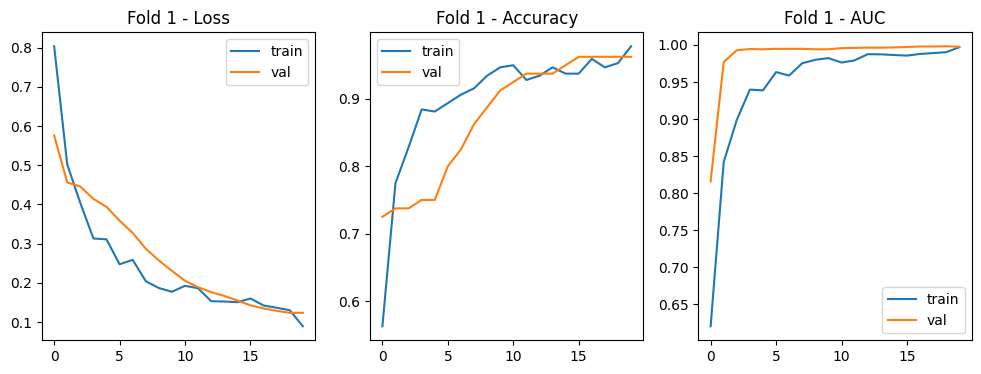

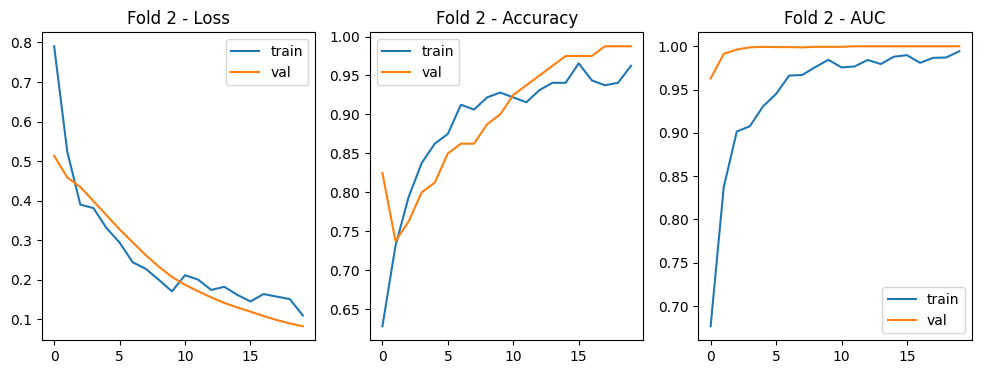

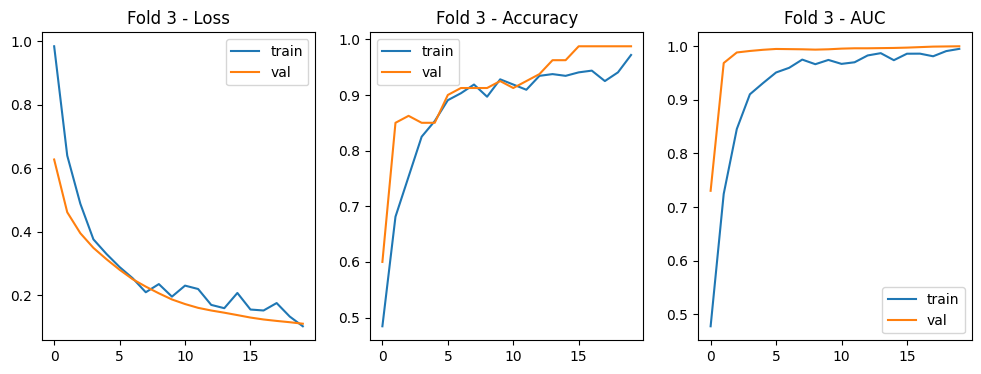

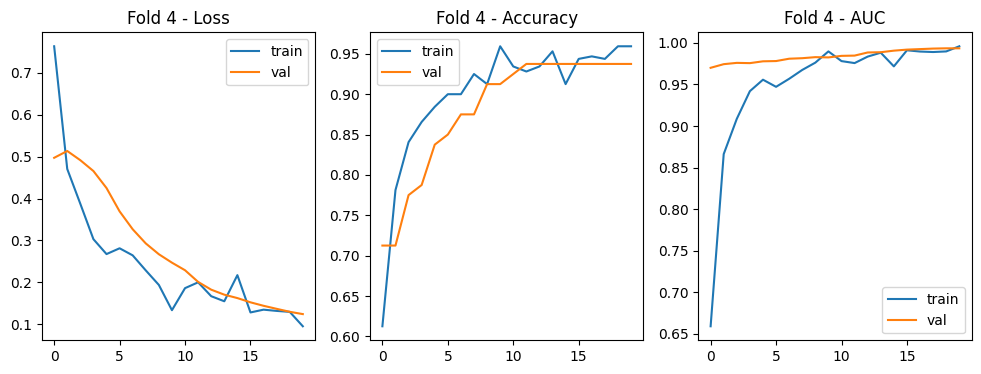

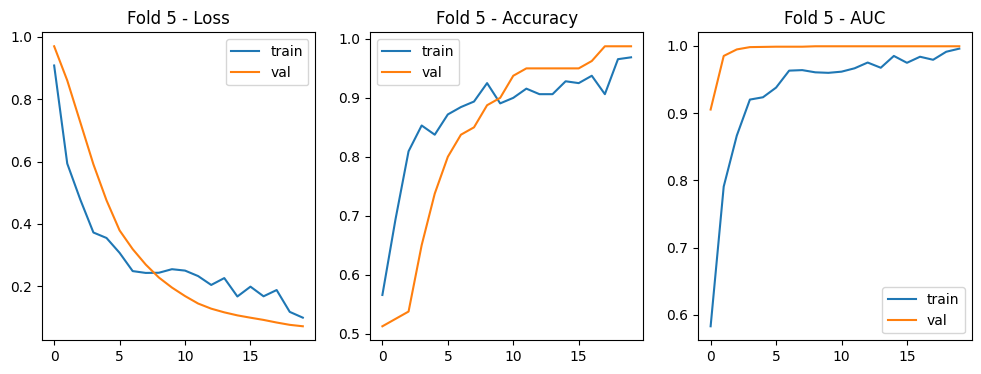

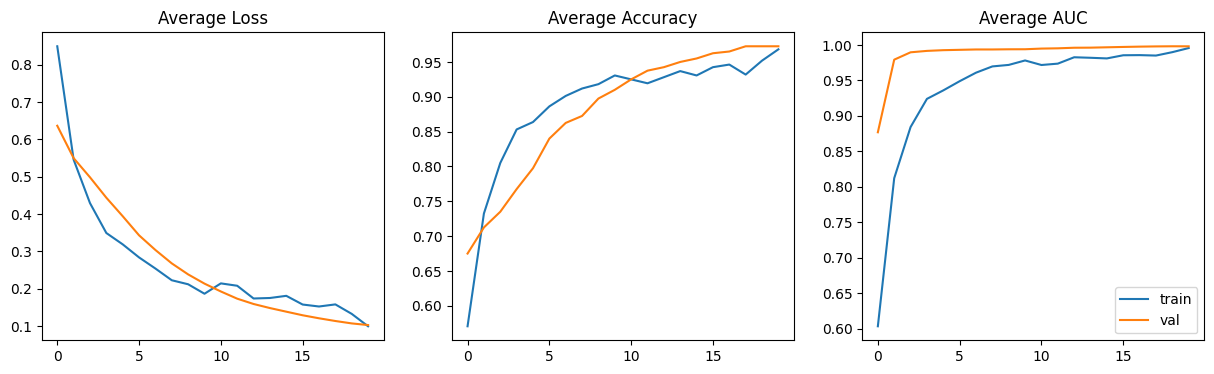

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - accuracy: 0.5075 - auc: 0.5641 - loss: 0.9476
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.7015 - auc: 0.8037 - loss: 0.5850
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.8428 - auc: 0.8965 - loss: 0.4128
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.8528 - auc: 0.9425 - loss: 0.3180
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 0.8682 - auc: 0.9398 - loss: 0.3142
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 236ms/step - accuracy: 0.8515 - auc: 0.9289 - loss: 0.3468
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.8862 - auc: 0.9596 - loss: 0.2625
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.9210 - auc: 0.9776 - loss: 0.1962
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.9083 - auc: 0.9784 - loss: 0.2020
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.9304 - auc: 0.9854 - loss: 0.166

In [6]:
# ============================================================
# RESNET101 + 5-FOLD STRATIFIED CV + FINE-TUNING
# WITH TIME, PLOTS, CONFUSION MATRICES, FINAL TEST EVALUATION
# ============================================================

!pip -q install tensorflow matplotlib scikit-learn

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 1) PATHS & PARAMETERS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 10
SEED = 42

CLASS_NAMES = ["normal", "tb"]

tf.random.set_seed(SEED)
np.random.seed(SEED)

# =========================
# 2) COLLECT TRAIN IMAGES
# =========================
image_paths, labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "train")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(folder, f))
            labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Training images:", len(image_paths))
print("Normal:", np.sum(labels == 0), "TB:", np.sum(labels == 1))

# =========================
# 3) DATASET BUILDER
# =========================
def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def parse(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        return img, tf.cast(label, tf.float32)

    ds = ds.map(parse, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000, seed=SEED)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 4) MODEL BUILDER (RESNET101)
# =========================
def build_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = tf.keras.layers.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.RandomRotation(0.05)(x)
    x = tf.keras.layers.RandomZoom(0.1)(x)

    x = tf.keras.applications.resnet.preprocess_input(x)

    base_model = tf.keras.applications.ResNet101(
        weights="imagenet",
        include_top=False,
        input_tensor=x
    )
    base_model.trainable = False  # Stage-1 frozen

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# =========================
# 5) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

histories = []
fold_times = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(image_paths, labels), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_dataset(image_paths[tr], labels[tr], True)
    val_ds   = make_dataset(image_paths[va], labels[va], False)

    model, base_model = build_model()

    # ---------- STAGE 1: FROZEN ----------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    t1 = time.time()
    hist1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE1,
        verbose=1
    )
    t1 = time.time() - t1

    # ---------- STAGE 2: FINE-TUNING ----------
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    t2 = time.time()
    hist2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE2,
        verbose=1
    )
    t2 = time.time() - t2

    fold_time = time.time() - fold_start
    fold_times.append((t1, t2, fold_time))

    print(f"Stage-1 time: {t1/60:.2f} min")
    print(f"Stage-2 time: {t2/60:.2f} min")
    print(f"Total fold time: {fold_time/60:.2f} min")

    # Merge histories
    history = {}
    for k in hist1.history:
        history[k] = hist1.history[k] + hist2.history[k]
    histories.append(history)

    # Fold confusion matrix
    y_true, y_pred = [], []
    for imgs, labs in val_ds:
        probs = model.predict(imgs, verbose=0).ravel()
        y_pred.extend((probs >= 0.5).astype(int))
        y_true.extend(labs.numpy().astype(int))

    print(f"\nFold {fold} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

cv_total_time = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total_time/60:.2f} minutes")

# =========================
# 6) FOLD-WISE TRAINING CURVES
# =========================
for i, h in enumerate(histories, 1):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.plot(h["loss"], label="train")
    plt.plot(h["val_loss"], label="val")
    plt.title(f"Fold {i} - Loss")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(h["accuracy"], label="train")
    plt.plot(h["val_accuracy"], label="val")
    plt.title(f"Fold {i} - Accuracy")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(h["auc"], label="train")
    plt.plot(h["val_auc"], label="val")
    plt.title(f"Fold {i} - AUC")
    plt.legend()

    plt.show()

# =========================
# 7) AVERAGE CV CURVES
# =========================
def avg_curve(key):
    return np.mean([h[key] for h in histories], axis=0)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(avg_curve("loss"), label="train")
plt.plot(avg_curve("val_loss"), label="val")
plt.title("Average Loss")

plt.subplot(1,3,2)
plt.plot(avg_curve("accuracy"), label="train")
plt.plot(avg_curve("val_accuracy"), label="val")
plt.title("Average Accuracy")

plt.subplot(1,3,3)
plt.plot(avg_curve("auc"), label="train")
plt.plot(avg_curve("val_auc"), label="val")
plt.title("Average AUC")

plt.legend()
plt.show()

# =========================
# 8) FINAL TRAIN ON FULL TRAIN SET
# =========================
final_model, final_base = build_model()

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

final_model.fit(
    make_dataset(image_paths, labels, True),
    epochs=EPOCHS_STAGE1,
    verbose=1
)

for layer in final_base.layers[-30:]:
    layer.trainable = True

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

final_model.fit(
    make_dataset(image_paths, labels, True),
    epochs=EPOCHS_STAGE2,
    verbose=1
)

# =========================
# 9) FINAL TEST EVALUATION
# =========================
test_paths, test_labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "test")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            test_paths.append(os.path.join(folder, f))
            test_labels.append(label)

test_ds = make_dataset(np.array(test_paths), np.array(test_labels), False)

y_true, y_pred = [], []
for imgs, labs in test_ds:
    probs = final_model.predict(imgs, verbose=0).ravel()
    y_pred.extend((probs >= 0.5).astype(int))
    y_true.extend(labs.numpy().astype(int))

print("\n===== FINAL TEST CONFUSION MATRIX =====")
print(confusion_matrix(y_true, y_pred))

print("\n===== FINAL TEST CLASSIFICATION REPORT =====")
print(classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES
))


# **denseNet**

Training images: 400
Normal: 200 TB: 200

========== FOLD 1 ==========
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5008 - auc: 0.5256 - loss: 0.9245 - val_accuracy: 0.4875 - val_auc: 0.4566 - val_loss: 0.8329
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 320ms/step - accuracy: 0.5654 - auc: 0.6734 - loss: 0.7416 - val_accuracy: 0.6125 - val_auc: 0.6288 - val_loss: 0.6679
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 358ms/step - accuracy: 0.6929 - auc: 0.8436 - loss: 0.5494 - val_accuracy: 0.6750 - val_auc: 0.7225 - val_loss: 0.6162
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.7254 - auc: 0.8328 - loss: 0.5039 - val_accuracy: 0.6625 - val_auc: 0.7916 - val_loss: 0.6071
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.7305 - auc: 0.8360 - loss: 0.5013 - val_accuracy: 0.6875 - val_auc: 0.8256 - val_loss: 0.6108
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.8277 - auc: 0

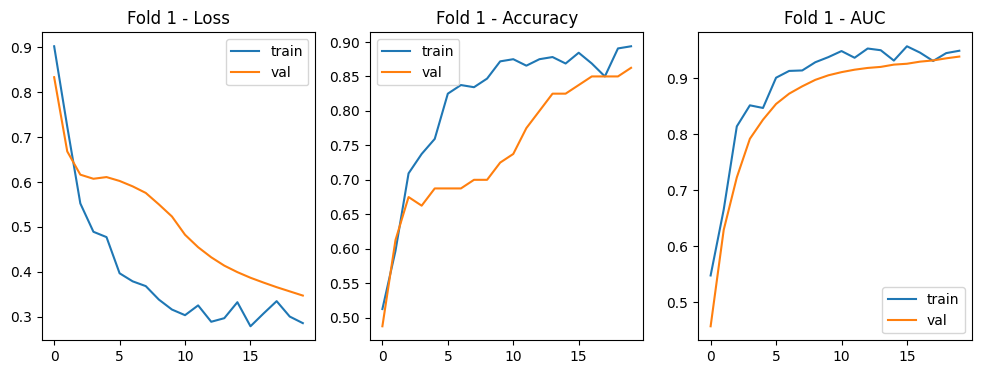

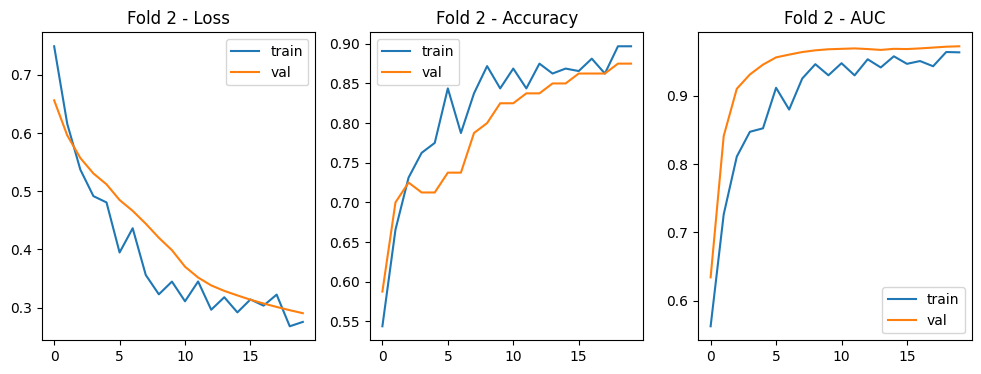

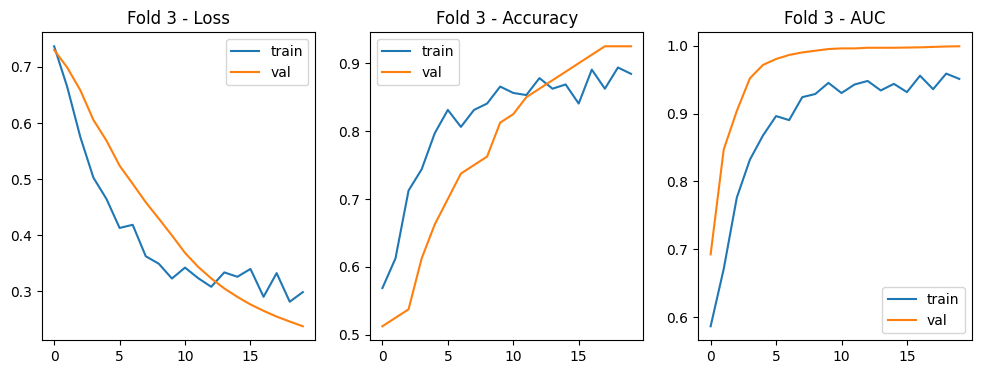

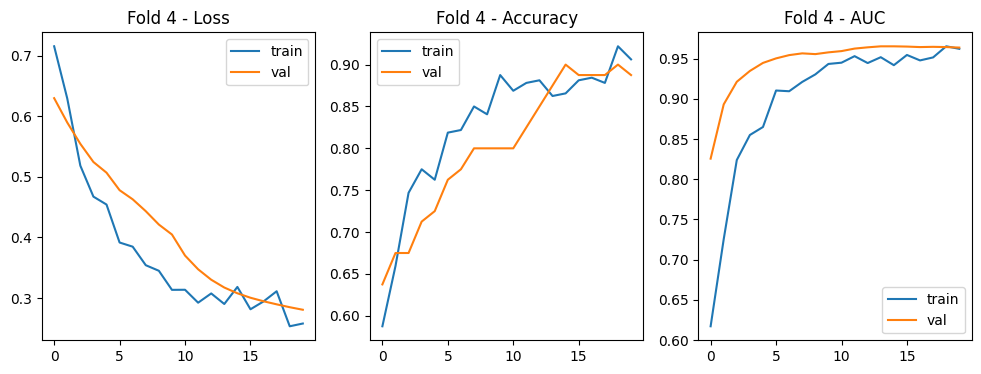

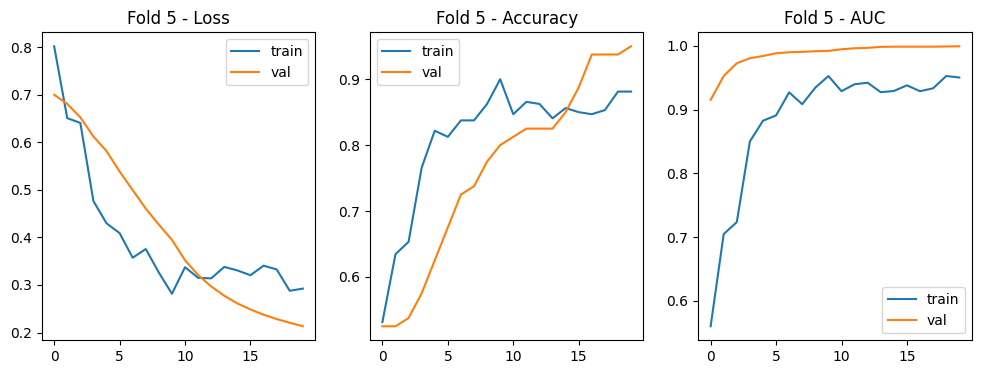

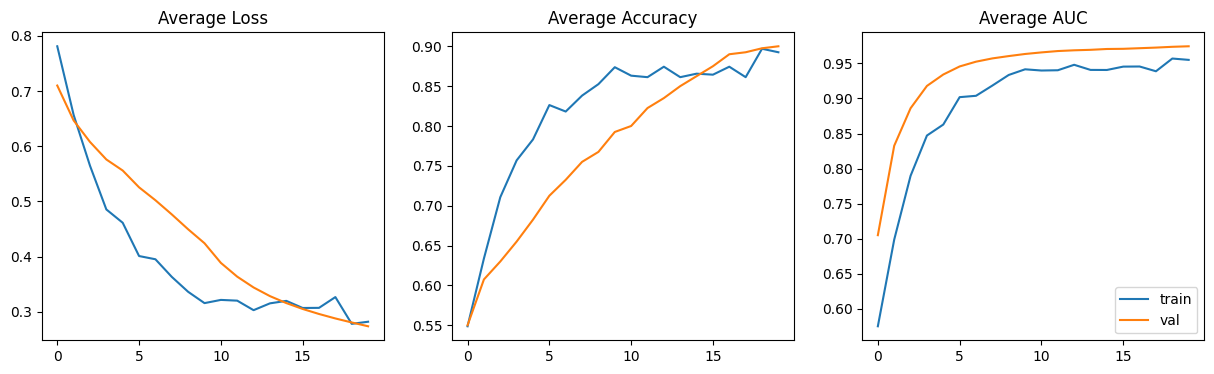

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.5685 - auc: 0.5875 - loss: 0.7864
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.6738 - auc: 0.7122 - loss: 0.6488
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.7358 - auc: 0.7827 - loss: 0.5582
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.7461 - auc: 0.8250 - loss: 0.5174
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.7417 - auc: 0.8227 - loss: 0.5147
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.8203 - auc: 0.9014 - loss: 0.3929
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.8171 - auc: 0.8970 - loss: 0.3905
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.8728 - auc: 0.9358 - loss: 0.3238
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.8634 - auc: 0.9405 - loss: 0.3262
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.8744 - auc: 0.9520 - loss: 0.303

In [7]:
# ============================================================
# DENSENET121 + 5-FOLD STRATIFIED CV + FINE-TUNING
# WITH TIME, PLOTS, CONFUSION MATRICES, FINAL TEST EVALUATION
# ============================================================

!pip -q install tensorflow matplotlib scikit-learn

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 1) PATHS & PARAMETERS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 10
SEED = 42

CLASS_NAMES = ["normal", "tb"]

tf.random.set_seed(SEED)
np.random.seed(SEED)

# =========================
# 2) COLLECT TRAIN IMAGES
# =========================
image_paths, labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "train")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(folder, f))
            labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Training images:", len(image_paths))
print("Normal:", np.sum(labels == 0), "TB:", np.sum(labels == 1))

# =========================
# 3) DATASET BUILDER
# =========================
def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def parse(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        return img, tf.cast(label, tf.float32)

    ds = ds.map(parse, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000, seed=SEED)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 4) MODEL BUILDER (DENSENET)
# =========================
def build_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = tf.keras.layers.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.RandomRotation(0.05)(x)
    x = tf.keras.layers.RandomZoom(0.1)(x)

    x = tf.keras.applications.densenet.preprocess_input(x)

    base_model = tf.keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        input_tensor=x
    )
    base_model.trainable = False  # Stage-1 frozen

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# =========================
# 5) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

histories = []
fold_times = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(image_paths, labels), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_dataset(image_paths[tr], labels[tr], True)
    val_ds   = make_dataset(image_paths[va], labels[va], False)

    model, base_model = build_model()

    # ---------- STAGE 1: FROZEN ----------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    t1 = time.time()
    hist1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE1,
        verbose=1
    )
    t1 = time.time() - t1

    # ---------- STAGE 2: FINE-TUNING ----------
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    t2 = time.time()
    hist2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE2,
        verbose=1
    )
    t2 = time.time() - t2

    fold_time = time.time() - fold_start
    fold_times.append((t1, t2, fold_time))

    print(f"Stage-1 time: {t1/60:.2f} min")
    print(f"Stage-2 time: {t2/60:.2f} min")
    print(f"Total fold time: {fold_time/60:.2f} min")

    # Merge histories
    history = {}
    for k in hist1.history:
        history[k] = hist1.history[k] + hist2.history[k]
    histories.append(history)

    # Fold confusion matrix
    y_true, y_pred = [], []
    for imgs, labs in val_ds:
        probs = model.predict(imgs, verbose=0).ravel()
        y_pred.extend((probs >= 0.5).astype(int))
        y_true.extend(labs.numpy().astype(int))

    print(f"\nFold {fold} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

cv_total_time = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total_time/60:.2f} minutes")

# =========================
# 6) FOLD-WISE TRAINING CURVES
# =========================
for i, h in enumerate(histories, 1):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.plot(h["loss"], label="train")
    plt.plot(h["val_loss"], label="val")
    plt.title(f"Fold {i} - Loss")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(h["accuracy"], label="train")
    plt.plot(h["val_accuracy"], label="val")
    plt.title(f"Fold {i} - Accuracy")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(h["auc"], label="train")
    plt.plot(h["val_auc"], label="val")
    plt.title(f"Fold {i} - AUC")
    plt.legend()

    plt.show()

# =========================
# 7) AVERAGE CV CURVES
# =========================
def avg_curve(key):
    return np.mean([h[key] for h in histories], axis=0)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(avg_curve("loss"), label="train")
plt.plot(avg_curve("val_loss"), label="val")
plt.title("Average Loss")

plt.subplot(1,3,2)
plt.plot(avg_curve("accuracy"), label="train")
plt.plot(avg_curve("val_accuracy"), label="val")
plt.title("Average Accuracy")

plt.subplot(1,3,3)
plt.plot(avg_curve("auc"), label="train")
plt.plot(avg_curve("val_auc"), label="val")
plt.title("Average AUC")

plt.legend()
plt.show()

# =========================
# 8) FINAL TRAIN ON FULL TRAIN SET
# =========================
final_model, final_base = build_model()

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

final_model.fit(
    make_dataset(image_paths, labels, True),
    epochs=EPOCHS_STAGE1,
    verbose=1
)

for layer in final_base.layers[-30:]:
    layer.trainable = True

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

final_model.fit(
    make_dataset(image_paths, labels, True),
    epochs=EPOCHS_STAGE2,
    verbose=1
)

# =========================
# 9) FINAL TEST EVALUATION
# =========================
test_paths, test_labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "test")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            test_paths.append(os.path.join(folder, f))
            test_labels.append(label)

test_ds = make_dataset(np.array(test_paths), np.array(test_labels), False)

y_true, y_pred = [], []
for imgs, labs in test_ds:
    probs = final_model.predict(imgs, verbose=0).ravel()
    y_pred.extend((probs >= 0.5).astype(int))
    y_true.extend(labs.numpy().astype(int))

print("\n===== FINAL TEST CONFUSION MATRIX =====")
print(confusion_matrix(y_true, y_pred))

print("\n===== FINAL TEST CLASSIFICATION REPORT =====")
print(classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES
))


# **vgg19**

In [ ]:
# ============================================================
# VGG19 + 5-FOLD STRATIFIED CV + FINE-TUNING
# WITH TIME, PLOTS, CONFUSION MATRICES, FINAL TEST EVALUATION
# ============================================================

!pip -q install tensorflow matplotlib scikit-learn

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# =========================
# 1) PATHS & PARAMETERS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 10
SEED = 42

CLASS_NAMES = ["normal", "tb"]

tf.random.set_seed(SEED)
np.random.seed(SEED)

# =========================
# 2) COLLECT TRAIN IMAGES
# =========================
image_paths, labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "train")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(folder, f))
            labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Training images:", len(image_paths))
print("Normal:", np.sum(labels == 0), "TB:", np.sum(labels == 1))

# =========================
# 3) DATASET BUILDER
# =========================
def make_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def parse(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        return img, tf.cast(label, tf.float32)

    ds = ds.map(parse, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(1000, seed=SEED)

    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 4) MODEL BUILDER (VGG19)
# =========================
def build_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))

    x = tf.keras.layers.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.RandomRotation(0.05)(x)
    x = tf.keras.layers.RandomZoom(0.1)(x)

    x = tf.keras.applications.vgg19.preprocess_input(x)

    base_model = tf.keras.applications.VGG19(
        weights="imagenet",
        include_top=False,
        input_tensor=x
    )
    base_model.trainable = False  # Stage-1 frozen

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    return model, base_model

# =========================
# 5) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

histories = []
fold_times = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(image_paths, labels), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_dataset(image_paths[tr], labels[tr], True)
    val_ds   = make_dataset(image_paths[va], labels[va], False)

    model, base_model = build_model()

    # ---------- STAGE 1: FROZEN ----------
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    t1 = time.time()
    hist1 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE1,
        verbose=1
    )
    t1 = time.time() - t1

    # ---------- STAGE 2: FINE-TUNING ----------
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    t2 = time.time()
    hist2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_STAGE2,
        verbose=1
    )
    t2 = time.time() - t2

    fold_time = time.time() - fold_start
    fold_times.append((t1, t2, fold_time))

    print(f"Stage-1 time: {t1/60:.2f} min")
    print(f"Stage-2 time: {t2/60:.2f} min")
    print(f"Total fold time: {fold_time/60:.2f} min")

    # Merge histories
    history = {}
    for k in hist1.history:
        history[k] = hist1.history[k] + hist2.history[k]
    histories.append(history)

    # Fold confusion matrix
    y_true, y_pred = [], []
    for imgs, labs in val_ds:
        probs = model.predict(imgs, verbose=0).ravel()
        y_pred.extend((probs >= 0.5).astype(int))
        y_true.extend(labs.numpy().astype(int))

    print(f"\nFold {fold} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

cv_total_time = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total_time/60:.2f} minutes")

# =========================
# 6) FOLD-WISE TRAINING CURVES
# =========================
for i, h in enumerate(histories, 1):
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.plot(h["loss"], label="train")
    plt.plot(h["val_loss"], label="val")
    plt.title(f"Fold {i} - Loss")
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(h["accuracy"], label="train")
    plt.plot(h["val_accuracy"], label="val")
    plt.title(f"Fold {i} - Accuracy")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(h["auc"], label="train")
    plt.plot(h["val_auc"], label="val")
    plt.title(f"Fold {i} - AUC")
    plt.legend()

    plt.show()

# =========================
# 7) AVERAGE CV CURVES
# =========================
def avg_curve(key):
    return np.mean([h[key] for h in histories], axis=0)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(avg_curve("loss"), label="train")
plt.plot(avg_curve("val_loss"), label="val")
plt.title("Average Loss")

plt.subplot(1,3,2)
plt.plot(avg_curve("accuracy"), label="train")
plt.plot(avg_curve("val_accuracy"), label="val")
plt.title("Average Accuracy")

plt.subplot(1,3,3)
plt.plot(avg_curve("auc"), label="train")
plt.plot(avg_curve("val_auc"), label="val")
plt.title("Average AUC")

plt.legend()
plt.show()

# =========================
# 8) FINAL TRAIN ON FULL TRAIN SET
# =========================
final_model, final_base = build_model()

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

final_model.fit(
    make_dataset(image_paths, labels, True),
    epochs=EPOCHS_STAGE1,
    verbose=1
)

for layer in final_base.layers[-8:]:
    layer.trainable = True

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

final_model.fit(
    make_dataset(image_paths, labels, True),
    epochs=EPOCHS_STAGE2,
    verbose=1
)

# =========================
# 9) FINAL TEST EVALUATION
# =========================
test_paths, test_labels = [], []

for label, cls in enumerate(CLASS_NAMES):
    folder = os.path.join(DATA_ROOT, cls, "test")
    for f in os.listdir(folder):
        if f.lower().endswith((".jpg", ".jpeg", ".png")):
            test_paths.append(os.path.join(folder, f))
            test_labels.append(label)

test_ds = make_dataset(np.array(test_paths), np.array(test_labels), False)

y_true, y_pred = [], []
for imgs, labs in test_ds:
    probs = final_model.predict(imgs, verbose=0).ravel()
    y_pred.extend((probs >= 0.5).astype(int))
    y_true.extend(labs.numpy().astype(int))

print("\n===== FINAL TEST CONFUSION MATRIX =====")
print(confusion_matrix(y_true, y_pred))

print("\n===== FINAL TEST CLASSIFICATION REPORT =====")
print(classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES
))


# **classical ml(rf)+ mobilenet feature**




In [ ]:
# ============================================================
# MOBILENETV2 FEATURES + RANDOM FOREST
# 5-FOLD STRATIFIED CV + FOLD-WISE EVALUATION + PLOTS
# ============================================================

!pip -q install tensorflow scikit-learn matplotlib

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, roc_auc_score, roc_curve
)

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# =========================
# 1) PATHS & PARAMS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
N_SPLITS = 5

CLASS_NAMES = ["normal", "tb"]

np.random.seed(SEED)
tf.random.set_seed(SEED)

# =========================
# 2) IMAGE COLLECTION
# =========================
def list_images(root):
    imgs = []
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                imgs.append(os.path.join(r, f))
    return imgs

normal_paths = list_images(os.path.join(DATA_ROOT, "normal", "train"))
tb_paths     = list_images(os.path.join(DATA_ROOT, "tb", "train"))

X_paths = np.array(normal_paths + tb_paths)
y = np.array([0]*len(normal_paths) + [1]*len(tb_paths))

print("Total training images:", len(X_paths))
print("Class distribution:", np.bincount(y))

# =========================
# 3) DATASET PIPELINE
# =========================
def load_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(tf.cast(img, tf.float32))
    return img, label

def make_ds(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 4) FEATURE EXTRACTOR
# =========================
feature_extractor = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"
)
feature_extractor.trainable = False

print("Feature dim:", feature_extractor.output_shape)

def extract_features(ds):
    feats, labs = [], []
    for x, y in ds:
        f = feature_extractor(x, training=False).numpy()
        feats.append(f)
        labs.append(y.numpy())
    return np.vstack(feats), np.concatenate(labs).astype(int)

# =========================
# 5) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_aucs = []
roc_curves = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(X_paths, y), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_ds(X_paths[tr], y[tr])
    val_ds   = make_ds(X_paths[va], y[va])

    # ---- Feature extraction
    Xf_train, yf_train = extract_features(train_ds)
    Xf_val, yf_val     = extract_features(val_ds)

    # ---- Random Forest
    rf = RandomForestClassifier(
        n_estimators=500,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample"
    )
    rf.fit(Xf_train, yf_train)

    # ---- Validation
    val_prob = rf.predict_proba(Xf_val)[:, 1]
    val_pred = (val_prob >= 0.5).astype(int)

    acc = accuracy_score(yf_val, val_pred)
    auc = roc_auc_score(yf_val, val_prob)
    fold_aucs.append(auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} AUC     : {auc:.4f}")

    print("Confusion Matrix:")
    print(confusion_matrix(yf_val, val_pred))

    print("Classification Report:")
    print(classification_report(
        yf_val, val_pred, target_names=CLASS_NAMES
    ))

    # ---- ROC curve
    fpr, tpr, _ = roc_curve(yf_val, val_prob)
    roc_curves.append((fpr, tpr))

    plt.figure()
    plt.plot(fpr, tpr, label=f"Fold {fold} AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"ROC – Fold {fold}")
    plt.legend()
    plt.show()

    print(f"Fold time: {(time.time()-fold_start)/60:.2f} min")

cv_total = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total/60:.2f} minutes")
print(f"Mean CV AUC: {np.mean(fold_aucs):.4f} ± {np.std(fold_aucs):.4f}")

# =========================
# 6) FINAL TRAIN ON FULL TRAIN SET
# =========================
full_ds = make_ds(X_paths, y)
Xf_full, yf_full = extract_features(full_ds)

final_rf = RandomForestClassifier(
    n_estimators=500,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
final_rf.fit(Xf_full, yf_full)

# =========================
# 7) FINAL TEST EVALUATION
# =========================
test_paths = list_images(os.path.join(DATA_ROOT, "normal", "test")) + \
             list_images(os.path.join(DATA_ROOT, "tb", "test"))

test_labels = [0]*len(list_images(os.path.join(DATA_ROOT,"normal","test"))) + \
              [1]*len(list_images(os.path.join(DATA_ROOT,"tb","test")))

test_ds = make_ds(np.array(test_paths), np.array(test_labels))
Xf_test, yf_test = extract_features(test_ds)

test_prob = final_rf.predict_proba(Xf_test)[:,1]
test_pred = (test_prob >= 0.5).astype(int)

print("\n===== FINAL TEST RESULTS =====")
print("Accuracy:", accuracy_score(yf_test, test_pred))
print("AUC     :", roc_auc_score(yf_test, test_prob))
print("Confusion Matrix:")
print(confusion_matrix(yf_test, test_pred))
print("Classification Report:")
print(classification_report(
    yf_test, test_pred, target_names=CLASS_NAMES
))

fpr, tpr, _ = roc_curve(yf_test, test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"Test AUC={roc_auc_score(yf_test, test_prob):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC – MobileNetV2 + RandomForest (Test)")
plt.legend()
plt.show()


# **classical ml (rf) + densenet121**

In [ ]:
# ============================================================
# DENSENET121 FEATURES + RANDOM FOREST
# 5-FOLD STRATIFIED CV + FOLD-WISE EVALUATION + PLOTS
# ============================================================

!pip -q install tensorflow scikit-learn matplotlib

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, roc_auc_score, roc_curve
)

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

# =========================
# 1) PATHS & PARAMS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
N_SPLITS = 5

CLASS_NAMES = ["normal", "tb"]

np.random.seed(SEED)
tf.random.set_seed(SEED)

# =========================
# 2) IMAGE COLLECTION (TRAIN ONLY)
# =========================
def list_images(root):
    imgs = []
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                imgs.append(os.path.join(r, f))
    return imgs

normal_paths = list_images(os.path.join(DATA_ROOT, "normal", "train"))
tb_paths     = list_images(os.path.join(DATA_ROOT, "tb", "train"))

X_paths = np.array(normal_paths + tb_paths)
y = np.array([0]*len(normal_paths) + [1]*len(tb_paths))

print("Total training images:", len(X_paths))
print("Class distribution:", np.bincount(y))

# =========================
# 3) TF DATA PIPELINE
# =========================
def load_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(tf.cast(img, tf.float32))
    return img, label

def make_ds(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 4) DENSENET FEATURE EXTRACTOR
# =========================
feature_extractor = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"   # 1024-d feature vector
)
feature_extractor.trainable = False

print("Feature dimension:", feature_extractor.output_shape)

def extract_features(ds):
    feats, labs = [], []
    for x, yb in ds:
        f = feature_extractor(x, training=False).numpy()
        feats.append(f)
        labs.append(yb.numpy())
    return np.vstack(feats), np.concatenate(labs).astype(int)

# =========================
# 5) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_aucs = []
roc_curves = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(X_paths, y), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_ds(X_paths[tr], y[tr])
    val_ds   = make_ds(X_paths[va], y[va])

    # ---- Feature extraction
    Xf_train, yf_train = extract_features(train_ds)
    Xf_val, yf_val     = extract_features(val_ds)

    # ---- Random Forest
    rf = RandomForestClassifier(
        n_estimators=500,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample"
    )
    rf.fit(Xf_train, yf_train)

    # ---- Validation
    val_prob = rf.predict_proba(Xf_val)[:, 1]
    val_pred = (val_prob >= 0.5).astype(int)

    acc = accuracy_score(yf_val, val_pred)
    auc = roc_auc_score(yf_val, val_prob)
    fold_aucs.append(auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} AUC     : {auc:.4f}")

    print("Confusion Matrix:")
    print(confusion_matrix(yf_val, val_pred))

    print("Classification Report:")
    print(classification_report(
        yf_val, val_pred, target_names=CLASS_NAMES
    ))

    # ---- ROC curve
    fpr, tpr, _ = roc_curve(yf_val, val_prob)
    roc_curves.append((fpr, tpr))

    plt.figure()
    plt.plot(fpr, tpr, label=f"Fold {fold} AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC – DenseNet121 + RF (Fold {fold})")
    plt.legend()
    plt.show()

    print(f"Fold time: {(time.time()-fold_start)/60:.2f} min")

cv_total = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total/60:.2f} minutes")
print(f"Mean CV AUC: {np.mean(fold_aucs):.4f} ± {np.std(fold_aucs):.4f}")

# =========================
# 6) FINAL TRAIN ON FULL TRAIN SET
# =========================
full_ds = make_ds(X_paths, y)
Xf_full, yf_full = extract_features(full_ds)

final_rf = RandomForestClassifier(
    n_estimators=500,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
final_rf.fit(Xf_full, yf_full)

# =========================
# 7) FINAL TEST EVALUATION
# =========================
test_normal = list_images(os.path.join(DATA_ROOT, "normal", "test"))
test_tb     = list_images(os.path.join(DATA_ROOT, "tb", "test"))

test_paths  = np.array(test_normal + test_tb)
test_labels = np.array([0]*len(test_normal) + [1]*len(test_tb))

test_ds = make_ds(test_paths, test_labels)
Xf_test, yf_test = extract_features(test_ds)

test_prob = final_rf.predict_proba(Xf_test)[:, 1]
test_pred = (test_prob >= 0.5).astype(int)

print("\n===== FINAL TEST RESULTS =====")
print("Accuracy:", accuracy_score(yf_test, test_pred))
print("AUC     :", roc_auc_score(yf_test, test_prob))

print("Confusion Matrix:")
print(confusion_matrix(yf_test, test_pred))

print("Classification Report:")
print(classification_report(
    yf_test, test_pred, target_names=CLASS_NAMES
))

fpr, tpr, _ = roc_curve(yf_test, test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"Test AUC={roc_auc_score(yf_test, test_prob):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – DenseNet121 + RandomForest (Test)")
plt.legend()
plt.show()


# **classical ml (rf) + resnet101**

In [ ]:
# ============================================================
# RESNET101 FEATURES + RANDOM FOREST
# 5-FOLD STRATIFIED CV + FOLD-WISE EVALUATION + PLOTS
# ============================================================

!pip -q install tensorflow scikit-learn matplotlib

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, roc_auc_score, roc_curve
)

from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input

# =========================
# 1) PATHS & PARAMETERS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
N_SPLITS = 5

CLASS_NAMES = ["normal", "tb"]

np.random.seed(SEED)
tf.random.set_seed(SEED)

# =========================
# 2) IMAGE COLLECTION (TRAIN ONLY)
# =========================
def list_images(root):
    imgs = []
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                imgs.append(os.path.join(r, f))
    return imgs

normal_paths = list_images(os.path.join(DATA_ROOT, "normal", "train"))
tb_paths     = list_images(os.path.join(DATA_ROOT, "tb", "train"))

X_paths = np.array(normal_paths + tb_paths)
y = np.array([0]*len(normal_paths) + [1]*len(tb_paths))

print("Total training images:", len(X_paths))
print("Class distribution:", np.bincount(y))

# =========================
# 3) TF DATA PIPELINE
# =========================
def load_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(tf.cast(img, tf.float32))
    return img, label

def make_ds(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 4) RESNET101 FEATURE EXTRACTOR
# =========================
feature_extractor = ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"   # 2048-d feature vector
)
feature_extractor.trainable = False

print("Feature dimension:", feature_extractor.output_shape)

def extract_features(ds):
    feats, labs = [], []
    for x, yb in ds:
        f = feature_extractor(x, training=False).numpy()
        feats.append(f)
        labs.append(yb.numpy())
    return np.vstack(feats), np.concatenate(labs).astype(int)

# =========================
# 5) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_aucs = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(X_paths, y), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_ds(X_paths[tr], y[tr])
    val_ds   = make_ds(X_paths[va], y[va])

    # ---- Feature extraction
    Xf_train, yf_train = extract_features(train_ds)
    Xf_val, yf_val     = extract_features(val_ds)

    # ---- Random Forest
    rf = RandomForestClassifier(
        n_estimators=500,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample"
    )
    rf.fit(Xf_train, yf_train)

    # ---- Validation
    val_prob = rf.predict_proba(Xf_val)[:, 1]
    val_pred = (val_prob >= 0.5).astype(int)

    acc = accuracy_score(yf_val, val_pred)
    auc = roc_auc_score(yf_val, val_prob)
    fold_aucs.append(auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} AUC     : {auc:.4f}")

    print("Confusion Matrix:")
    print(confusion_matrix(yf_val, val_pred))

    print("Classification Report:")
    print(classification_report(
        yf_val, val_pred, target_names=CLASS_NAMES
    ))

    # ---- ROC curve
    fpr, tpr, _ = roc_curve(yf_val, val_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Fold {fold} AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC – ResNet101 + RF (Fold {fold})")
    plt.legend()
    plt.show()

    print(f"Fold time: {(time.time()-fold_start)/60:.2f} min")

cv_total = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total/60:.2f} minutes")
print(f"Mean CV AUC: {np.mean(fold_aucs):.4f} ± {np.std(fold_aucs):.4f}")

# =========================
# 6) FINAL TRAIN ON FULL TRAIN SET
# =========================
full_ds = make_ds(X_paths, y)
Xf_full, yf_full = extract_features(full_ds)

final_rf = RandomForestClassifier(
    n_estimators=500,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
final_rf.fit(Xf_full, yf_full)

# =========================
# 7) FINAL TEST EVALUATION
# =========================
test_normal = list_images(os.path.join(DATA_ROOT, "normal", "test"))
test_tb     = list_images(os.path.join(DATA_ROOT, "tb", "test"))

test_paths  = np.array(test_normal + test_tb)
test_labels = np.array([0]*len(test_normal) + [1]*len(test_tb))

test_ds = make_ds(test_paths, test_labels)
Xf_test, yf_test = extract_features(test_ds)

test_prob = final_rf.predict_proba(Xf_test)[:, 1]
test_pred = (test_prob >= 0.5).astype(int)

print("\n===== FINAL TEST RESULTS =====")
print("Accuracy:", accuracy_score(yf_test, test_pred))
print("AUC     :", roc_auc_score(yf_test, test_prob))

print("Confusion Matrix:")
print(confusion_matrix(yf_test, test_pred))

print("Classification Report:")
print(classification_report(
    yf_test, test_pred, target_names=CLASS_NAMES
))

fpr, tpr, _ = roc_curve(yf_test, test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"Test AUC={roc_auc_score(yf_test, test_prob):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – ResNet101 + RandomForest (Test)")
plt.legend()
plt.show()


# **classical ml (rf) + resnet50**

In [ ]:
# ============================================================
# RESNET50 FEATURES + RANDOM FOREST
# 5-FOLD STRATIFIED CV + FOLD-WISE EVALUATION + PLOTS
# ============================================================

!pip -q install tensorflow scikit-learn matplotlib

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, roc_auc_score, roc_curve
)

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

# =========================
# 1) PATHS & PARAMETERS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
N_SPLITS = 5

CLASS_NAMES = ["normal", "tb"]

np.random.seed(SEED)
tf.random.set_seed(SEED)

# =========================
# 2) IMAGE COLLECTION (TRAIN ONLY)
# =========================
def list_images(root):
    imgs = []
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                imgs.append(os.path.join(r, f))
    return imgs

normal_paths = list_images(os.path.join(DATA_ROOT, "normal", "train"))
tb_paths     = list_images(os.path.join(DATA_ROOT, "tb", "train"))

X_paths = np.array(normal_paths + tb_paths)
y = np.array([0]*len(normal_paths) + [1]*len(tb_paths))

print("Total training images:", len(X_paths))
print("Class distribution:", np.bincount(y))

# =========================
# 3) TF DATA PIPELINE
# =========================
def load_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(tf.cast(img, tf.float32))
    return img, label

def make_ds(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 4) RESNET50 FEATURE EXTRACTOR
# =========================
feature_extractor = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"   # 2048-d feature vector
)
feature_extractor.trainable = False

print("Feature dimension:", feature_extractor.output_shape)

def extract_features(ds):
    feats, labs = [], []
    for x, yb in ds:
        f = feature_extractor(x, training=False).numpy()
        feats.append(f)
        labs.append(yb.numpy())
    return np.vstack(feats), np.concatenate(labs).astype(int)

# =========================
# 5) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_aucs = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(X_paths, y), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_ds(X_paths[tr], y[tr])
    val_ds   = make_ds(X_paths[va], y[va])

    # ---- Feature extraction
    Xf_train, yf_train = extract_features(train_ds)
    Xf_val, yf_val     = extract_features(val_ds)

    # ---- Random Forest
    rf = RandomForestClassifier(
        n_estimators=500,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample"
    )
    rf.fit(Xf_train, yf_train)

    # ---- Validation
    val_prob = rf.predict_proba(Xf_val)[:, 1]
    val_pred = (val_prob >= 0.5).astype(int)

    acc = accuracy_score(yf_val, val_pred)
    auc = roc_auc_score(yf_val, val_prob)
    fold_aucs.append(auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} AUC     : {auc:.4f}")

    print("Confusion Matrix:")
    print(confusion_matrix(yf_val, val_pred))

    print("Classification Report:")
    print(classification_report(
        yf_val, val_pred, target_names=CLASS_NAMES
    ))

    # ---- ROC curve
    fpr, tpr, _ = roc_curve(yf_val, val_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Fold {fold} AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC – ResNet50 + RF (Fold {fold})")
    plt.legend()
    plt.show()

    print(f"Fold time: {(time.time()-fold_start)/60:.2f} min")

cv_total = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total/60:.2f} minutes")
print(f"Mean CV AUC: {np.mean(fold_aucs):.4f} ± {np.std(fold_aucs):.4f}")

# =========================
# 6) FINAL TRAIN ON FULL TRAIN SET
# =========================
full_ds = make_ds(X_paths, y)
Xf_full, yf_full = extract_features(full_ds)

final_rf = RandomForestClassifier(
    n_estimators=500,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
final_rf.fit(Xf_full, yf_full)

# =========================
# 7) FINAL TEST EVALUATION
# =========================
test_normal = list_images(os.path.join(DATA_ROOT, "normal", "test"))
test_tb     = list_images(os.path.join(DATA_ROOT, "tb", "test"))

test_paths  = np.array(test_normal + test_tb)
test_labels = np.array([0]*len(test_normal) + [1]*len(test_tb))

test_ds = make_ds(test_paths, test_labels)
Xf_test, yf_test = extract_features(test_ds)

test_prob = final_rf.predict_proba(Xf_test)[:, 1]
test_pred = (test_prob >= 0.5).astype(int)

print("\n===== FINAL TEST RESULTS =====")
print("Accuracy:", accuracy_score(yf_test, test_pred))
print("AUC     :", roc_auc_score(yf_test, test_prob))

print("Confusion Matrix:")
print(confusion_matrix(yf_test, test_pred))

print("Classification Report:")
print(classification_report(
    yf_test, test_pred, target_names=CLASS_NAMES
))

fpr, tpr, _ = roc_curve(yf_test, test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"Test AUC={roc_auc_score(yf_test, test_prob):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – ResNet50 + RandomForest (Test)")
plt.legend()
plt.show()


# **classical ml(rf) + vgg19**

In [ ]:
# ============================================================
# VGG19 FEATURES + RANDOM FOREST
# 5-FOLD STRATIFIED CV + FOLD-WISE EVALUATION + PLOTS
# ============================================================

!pip -q install tensorflow scikit-learn matplotlib

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, roc_auc_score, roc_curve
)

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

# =========================
# 1) PATHS & PARAMETERS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
N_SPLITS = 5

CLASS_NAMES = ["normal", "tb"]

np.random.seed(SEED)
tf.random.set_seed(SEED)

# =========================
# 2) IMAGE COLLECTION (TRAIN ONLY)
# =========================
def list_images(root):
    imgs = []
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                imgs.append(os.path.join(r, f))
    return imgs

normal_paths = list_images(os.path.join(DATA_ROOT, "normal", "train"))
tb_paths     = list_images(os.path.join(DATA_ROOT, "tb", "train"))

X_paths = np.array(normal_paths + tb_paths)
y = np.array([0]*len(normal_paths) + [1]*len(tb_paths))

print("Total training images:", len(X_paths))
print("Class distribution:", np.bincount(y))

# =========================
# 3) TF DATA PIPELINE
# =========================
def load_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(tf.cast(img, tf.float32))
    return img, label

def make_ds(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 4) VGG19 FEATURE EXTRACTOR
# =========================
feature_extractor = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"   # 512-d feature vector
)
feature_extractor.trainable = False

print("Feature dimension:", feature_extractor.output_shape)

def extract_features(ds):
    feats, labs = [], []
    for x, yb in ds:
        f = feature_extractor(x, training=False).numpy()
        feats.append(f)
        labs.append(yb.numpy())
    return np.vstack(feats), np.concatenate(labs).astype(int)

# =========================
# 5) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_aucs = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(X_paths, y), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_ds(X_paths[tr], y[tr])
    val_ds   = make_ds(X_paths[va], y[va])

    # ---- Feature extraction
    Xf_train, yf_train = extract_features(train_ds)
    Xf_val, yf_val     = extract_features(val_ds)

    # ---- Random Forest
    rf = RandomForestClassifier(
        n_estimators=500,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample"
    )
    rf.fit(Xf_train, yf_train)

    # ---- Validation
    val_prob = rf.predict_proba(Xf_val)[:, 1]
    val_pred = (val_prob >= 0.5).astype(int)

    acc = accuracy_score(yf_val, val_pred)
    auc = roc_auc_score(yf_val, val_prob)
    fold_aucs.append(auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} AUC     : {auc:.4f}")

    print("Confusion Matrix:")
    print(confusion_matrix(yf_val, val_pred))

    print("Classification Report:")
    print(classification_report(
        yf_val, val_pred, target_names=CLASS_NAMES
    ))

    # ---- ROC curve
    fpr, tpr, _ = roc_curve(yf_val, val_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Fold {fold} AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC – VGG19 + RF (Fold {fold})")
    plt.legend()
    plt.show()

    print(f"Fold time: {(time.time()-fold_start)/60:.2f} min")

cv_total = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total/60:.2f} minutes")
print(f"Mean CV AUC: {np.mean(fold_aucs):.4f} ± {np.std(fold_aucs):.4f}")

# =========================
# 6) FINAL TRAIN ON FULL TRAIN SET
# =========================
full_ds = make_ds(X_paths, y)
Xf_full, yf_full = extract_features(full_ds)

final_rf = RandomForestClassifier(
    n_estimators=500,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
final_rf.fit(Xf_full, yf_full)

# =========================
# 7) FINAL TEST EVALUATION
# =========================
test_normal = list_images(os.path.join(DATA_ROOT, "normal", "test"))
test_tb     = list_images(os.path.join(DATA_ROOT, "tb", "test"))

test_paths  = np.array(test_normal + test_tb)
test_labels = np.array([0]*len(test_normal) + [1]*len(test_tb))

test_ds = make_ds(test_paths, test_labels)
Xf_test, yf_test = extract_features(test_ds)

test_prob = final_rf.predict_proba(Xf_test)[:, 1]
test_pred = (test_prob >= 0.5).astype(int)

print("\n===== FINAL TEST RESULTS =====")
print("Accuracy:", accuracy_score(yf_test, test_pred))
print("AUC     :", roc_auc_score(yf_test, test_prob))

print("Confusion Matrix:")
print(confusion_matrix(yf_test, test_pred))

print("Classification Report:")
print(classification_report(
    yf_test, test_pred, target_names=CLASS_NAMES
))

fpr, tpr, _ = roc_curve(yf_test, test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"Test AUC={roc_auc_score(yf_test, test_prob):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – VGG19 + RandomForest (Test)")
plt.legend()
plt.show()


# **classical ml(rf) + efficentnet**

In [ ]:
# ============================================================
# EFFICIENTNETB0 FEATURES + RANDOM FOREST
# 5-FOLD STRATIFIED CV + FOLD-WISE EVALUATION + PLOTS
# ============================================================

!pip -q install tensorflow scikit-learn matplotlib

import os, time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, roc_auc_score, roc_curve
)

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# =========================
# 1) PATHS & PARAMETERS
# =========================
DATA_ROOT = "/content/drive/MyDrive/data_For_research"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
N_SPLITS = 5

CLASS_NAMES = ["normal", "tb"]

np.random.seed(SEED)
tf.random.set_seed(SEED)

# =========================
# 2) IMAGE COLLECTION (TRAIN ONLY)
# =========================
def list_images(root):
    imgs = []
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                imgs.append(os.path.join(r, f))
    return imgs

normal_paths = list_images(os.path.join(DATA_ROOT, "normal", "train"))
tb_paths     = list_images(os.path.join(DATA_ROOT, "tb", "train"))

X_paths = np.array(normal_paths + tb_paths)
y = np.array([0]*len(normal_paths) + [1]*len(tb_paths))

print("Total training images:", len(X_paths))
print("Class distribution:", np.bincount(y))

# =========================
# 3) TF DATA PIPELINE
# =========================
def load_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(tf.cast(img, tf.float32))
    return img, label

def make_ds(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# =========================
# 4) EFFICIENTNETB0 FEATURE EXTRACTOR
# =========================
feature_extractor = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"   # 1280-d feature vector
)
feature_extractor.trainable = False

print("Feature dimension:", feature_extractor.output_shape)

def extract_features(ds):
    feats, labs = [], []
    for x, yb in ds:
        f = feature_extractor(x, training=False).numpy()
        feats.append(f)
        labs.append(yb.numpy())
    return np.vstack(feats), np.concatenate(labs).astype(int)

# =========================
# 5) 5-FOLD STRATIFIED CV
# =========================
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_aucs = []

cv_start = time.time()

for fold, (tr, va) in enumerate(skf.split(X_paths, y), 1):
    print(f"\n========== FOLD {fold} ==========")
    fold_start = time.time()

    train_ds = make_ds(X_paths[tr], y[tr])
    val_ds   = make_ds(X_paths[va], y[va])

    # ---- Feature extraction
    Xf_train, yf_train = extract_features(train_ds)
    Xf_val, yf_val     = extract_features(val_ds)

    # ---- Random Forest
    rf = RandomForestClassifier(
        n_estimators=500,
        random_state=SEED,
        n_jobs=-1,
        class_weight="balanced_subsample"
    )
    rf.fit(Xf_train, yf_train)

    # ---- Validation
    val_prob = rf.predict_proba(Xf_val)[:, 1]
    val_pred = (val_prob >= 0.5).astype(int)

    acc = accuracy_score(yf_val, val_pred)
    auc = roc_auc_score(yf_val, val_prob)
    fold_aucs.append(auc)

    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} AUC     : {auc:.4f}")

    print("Confusion Matrix:")
    print(confusion_matrix(yf_val, val_pred))

    print("Classification Report:")
    print(classification_report(
        yf_val, val_pred, target_names=CLASS_NAMES
    ))

    # ---- ROC curve
    fpr, tpr, _ = roc_curve(yf_val, val_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Fold {fold} AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC – EfficientNetB0 + RF (Fold {fold})")
    plt.legend()
    plt.show()

    print(f"Fold time: {(time.time()-fold_start)/60:.2f} min")

cv_total = time.time() - cv_start
print(f"\nTOTAL CV TIME: {cv_total/60:.2f} minutes")
print(f"Mean CV AUC: {np.mean(fold_aucs):.4f} ± {np.std(fold_aucs):.4f}")

# =========================
# 6) FINAL TRAIN ON FULL TRAIN SET
# =========================
full_ds = make_ds(X_paths, y)
Xf_full, yf_full = extract_features(full_ds)

final_rf = RandomForestClassifier(
    n_estimators=500,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
final_rf.fit(Xf_full, yf_full)

# =========================
# 7) FINAL TEST EVALUATION
# =========================
test_normal = list_images(os.path.join(DATA_ROOT, "normal", "test"))
test_tb     = list_images(os.path.join(DATA_ROOT, "tb", "test"))

test_paths  = np.array(test_normal + test_tb)
test_labels = np.array([0]*len(test_normal) + [1]*len(test_tb))

test_ds = make_ds(test_paths, test_labels)
Xf_test, yf_test = extract_features(test_ds)

test_prob = final_rf.predict_proba(Xf_test)[:, 1]
test_pred = (test_prob >= 0.5).astype(int)

print("\n===== FINAL TEST RESULTS =====")
print("Accuracy:", accuracy_score(yf_test, test_pred))
print("AUC     :", roc_auc_score(yf_test, test_prob))

print("Confusion Matrix:")
print(confusion_matrix(yf_test, test_pred))

print("Classification Report:")
print(classification_report(
    yf_test, test_pred, target_names=CLASS_NAMES
))

fpr, tpr, _ = roc_curve(yf_test, test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"Test AUC={roc_auc_score(yf_test, test_prob):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC – EfficientNetB0 + RandomForest (Test)")
plt.legend()
plt.show()
